# Cleaning data in R
## -- DataCamp - Data Scientist - Course 12 --
### + DataCamp - Dealing with Missing Data in R 

 **Note**

This Notebook was made using two DataCamp courses.
To use this code, select the R environment in Anaconda.
 
 **Used packages**
 - tidyverse
 - lubridate
 - assertive
 - visdat
 - stringdist
 - fuzzyjoin
 - reclin2
 - naniar
 - simputation
 
**Table of content**
- [&nbsp;&nbsp;1. Common Data Problems](#toc_00232_1)
    - [&nbsp;&nbsp;1.1 Data type constraints](#toc_00232_1.1)
    - [&nbsp;&nbsp;1.2 Range constraints](#toc_00232_1.2)
    - [&nbsp;&nbsp;1.3 Uniqueness constraints](#toc_00232_1.2)
- [&nbsp;&nbsp;2. Categorical and text data](#toc_00232_2)
    - [&nbsp;&nbsp;2.1 Membership constraints](#toc_00232_2.1)
    - [&nbsp;&nbsp;2.2 Inconsistency within categories](#toc_00232_2.2)
    - [&nbsp;&nbsp;2.3 Inconsistent units or date formats](#toc_00232_2.3)
- [&nbsp;&nbsp;3. Cross field validation](#toc_00232_3)
- [&nbsp;&nbsp;4 Completeness and missing data](#toc_00232_4)
- [&nbsp;&nbsp;5. Record Linkage](#toc_00232_5)
    - [&nbsp;&nbsp;5.1 Comparing strings using edit distance](#toc_00232_5.1)
    - [&nbsp;&nbsp;5.2 Record linkage: Generating and comparing pairs](#toc_00232_5.2)

**Set environment and plot size**

In [91]:
suppressMessages(library(tidyverse))
suppressMessages(library(lubridate))
suppressMessages(library(assertive))
suppressMessages(library(visdat))
suppressMessages(library(stringdist))
suppressMessages(library(fuzzyjoin))
suppressMessages(library(reclin2))
suppressMessages(library(naniar))
suppressMessages(library(simputation))
suppressMessages(library(broom))

Note: if the above code return an error message:
- Check that the correct R environment is selected in Anaconda
- Restart computer

**Import data**

In [4]:
bike <- readRDS("data/cleaning/bike_share_rides_ch1_1.RDS")
accounts <- readRDS("data/cleaning/ch3_1_accounts.RDS")
fodors <- readRDS("data/cleaning/fodors.RDS")
survey <- readRDS("data/cleaning/sfo_survey_ch2_1.RDS")
zagat <- readRDS("data/cleaning/zagat.RDS")

<a name="toc_00232_1"></a>
## 1.   Common Data Problems

Dirty data can appear before we even access the data, due to mistakes such as typos and misspellings. If we don't address these mistakes early on, they'll follow us through our entire workflow, which means we could end up drawing incorrect conclusions.

<a name="toc_00232_1.1"></a>
**1.1   Data type constraints**

You've probably encountered different types of data before, such as text, numbers, categories, and dates. Each of these data types is treated differently, so if each variable isn't the correct data type, we risk compromising our analysis.

For example in the below table, revenue is character, but it should be numeric.

<div style="text-align:center;">
  <img src="images/clean_01.png" width = "700" align="center">
</div>

We can use the `class()` function on the revenue column to see that it's a `character` type. Alternatively, we can use the `is.numeric()` function on the revenue column and see that it's not numeric. Another way to do this check is to use the `assert_is_numeric()` function from the `assertive` package. This provides extra protection because it will throw an error and stop our script from running, so we'll immediately know that something's amiss. If we call `assert_is_numeric()` on something that is numeric, nothing is returned.

<div style="text-align:center;">
  <img src="images/clean_02.png" width = "700" align="center">
</div>

If we want to know what the average revenue is, we get an `NA` and a warning, since taking the mean of text doesn't make much sense. We'll need to convert this column to a numeric type in order to get the average.

Printing revenue shows a comma in each number. We'll need to remove them before converting the strings to numbers. This can be done using `str_remove(sales$revenue, ",")` from the `stringr` package. Then we can use `as.numeric()` to convert the values to numeric.

<div style="text-align:center;">
  <img src="images/clean_03.png" width = "500" align="center">
</div>

But, be careful when converting a **factor to a numeric**. Factors are a data type that represent a limited set of possible categories. If we call `as.numeric` on a factor, we get numbers corresponding to the factor levels, which isn't what we're looking for. This is due to the way that factors are encoded in R. Instead, we need to use `as.character` first, and then `as.numeric`.

<div style="text-align:center;">
  <img src="images/clean_04.png" width = "600" align="center">
</div>

In [5]:
glimpse(bike)

Rows: 35,229
Columns: 10
$ ride_id         <int> 52797, 54540, 87695, 45619, 70832, 96135, 29928, 83331~
$ date            <chr> "2017-04-15", "2017-04-19", "2017-04-14", "2017-04-03"~
$ duration        <chr> "1316.15 minutes", "8.13 minutes", "24.85 minutes", "6~
$ station_A_id    <dbl> 67, 21, 16, 58, 16, 6, 5, 16, 5, 81, 30, 16, 16, 67, 2~
$ station_A_name  <chr> "San Francisco Caltrain Station 2  (Townsend St at 4th~
$ station_B_id    <dbl> 89, 64, 355, 368, 81, 66, 350, 91, 62, 81, 109, 10, 80~
$ station_B_name  <chr> "Division St at Potrero Ave", "5th St at Brannan St", ~
$ bike_id         <dbl> 1974, 860, 2263, 1417, 507, 75, 388, 239, 1449, 3289, ~
$ user_gender     <chr> "Male", "Male", "Male", "Male", "Male", "Male", "Male"~
$ user_birth_year <dbl> 1972, 1986, 1993, 1981, 1981, 1988, 1993, 1996, 1993, ~


In [6]:
summary(bike$user_birth_year)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1900    1979    1986    1984    1991    2001 

☝️ This is not very useful. The `user_birth_year` variable represent groupings of data, so it should be converted to factor instead.

In [7]:
bike2 <- bike %>%
  mutate(user_birth_year_fct = as.factor(user_birth_year))

summary(bike2$user_birth_year_fct)

1900 1902 1923 1931 1938 1939 1941 1942 1943 1945 1946 1947 1948 1949 1950 1951 
   1    7    2   23    2    1    3   10    4   16    5   24    9   30   37   25 
1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 
  70   49   65   66  112   62  156   99  196  161  256  237  245  349  225  363 
1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 
 365  331  370  548  529  527  563  601  481  541  775  876  825 1016 1056 1262 
1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 
1157 1318 1606 1672 2135 1872 2062 1582 1703 1498 1476 1185  813  358  365  348 
2000 2001 
 473   30

The `duration` column is not very useful either. We need to trim the strings.

In [8]:
bike3 <- bike %>%
  mutate(duration_trimmed = str_remove(duration, "minutes"),
         duration_mins = as.numeric(duration_trimmed))

glimpse(bike3)
mean(bike3$duration_mins)

Rows: 35,229
Columns: 12
$ ride_id          <int> 52797, 54540, 87695, 45619, 70832, 96135, 29928, 8333~
$ date             <chr> "2017-04-15", "2017-04-19", "2017-04-14", "2017-04-03~
$ duration         <chr> "1316.15 minutes", "8.13 minutes", "24.85 minutes", "~
$ station_A_id     <dbl> 67, 21, 16, 58, 16, 6, 5, 16, 5, 81, 30, 16, 16, 67, ~
$ station_A_name   <chr> "San Francisco Caltrain Station 2  (Townsend St at 4t~
$ station_B_id     <dbl> 89, 64, 355, 368, 81, 66, 350, 91, 62, 81, 109, 10, 8~
$ station_B_name   <chr> "Division St at Potrero Ave", "5th St at Brannan St",~
$ bike_id          <dbl> 1974, 860, 2263, 1417, 507, 75, 388, 239, 1449, 3289,~
$ user_gender      <chr> "Male", "Male", "Male", "Male", "Male", "Male", "Male~
$ user_birth_year  <dbl> 1972, 1986, 1993, 1981, 1981, 1988, 1993, 1996, 1993,~
$ duration_trimmed <chr> "1316.15 ", "8.13 ", "24.85 ", "6.35 ", "9.8 ", "17.4~
$ duration_mins    <dbl> 1316.15, 8.13, 24.85, 6.35, 9.80, 17.47, 16.52, 14.72~


[1] 13.06214

<a name="toc_00232_1.2"></a>
**1.2   Range constraints**

Many variables have some range that you can reasonably expect all of the data points to fall within. For example, the college entrance test in the US is scored between 400 and 1600, so there shouldn't be any scores below 400 or above 1600. Other examples are the weight of a package, which can't be negative, or in movie ratings using a five-star system, all ratings should fall between 0 and 5. Since we know what these reasonable ranges are, we know that there's something off if we see a weight of -5 pounds in our dataset. 

We can also use the `assert_all_are_in_closed_range()` function from the `assertive` package, which takes in a `lower` value and an `upper` value. It will give an error if anything falls outside of the specified range. Dates can also be out of range. A common scenario is when data contains dates in the future. We can use the `assert_all_are_in_past` function to check for future dates, and it looks like we have one.

Once we identify that there are values out of range, how do we deal with them?
- We could remove those data points completely, but this should only be done when only a small proportion of the values are out of range, otherwise, we would significantly increase the amount of bias in our dataset. We can do this with `filter()`.
- We could also treat each out of range value as `missing`, or replace it with `NA`. This allows us to use different **imputation** techniques for missing data. We can do this with `mutate(var2 = replace(var1, var1 > 5, 5))`.
- We can also replace out of range values with the range limit. For example, if we know our ratings should fall between 0 and 5 and there's a value of 6, we can replace the 6 with 5 so that it's in range. 
- Finally, we can replace the values with some other number based on our knowledge of the dataset. For example, we could replace them with the average rating of all movies.

In [9]:
glimpse(bike)

Rows: 35,229
Columns: 10
$ ride_id         <int> 52797, 54540, 87695, 45619, 70832, 96135, 29928, 83331~
$ date            <chr> "2017-04-15", "2017-04-19", "2017-04-14", "2017-04-03"~
$ duration        <chr> "1316.15 minutes", "8.13 minutes", "24.85 minutes", "6~
$ station_A_id    <dbl> 67, 21, 16, 58, 16, 6, 5, 16, 5, 81, 30, 16, 16, 67, 2~
$ station_A_name  <chr> "San Francisco Caltrain Station 2  (Townsend St at 4th~
$ station_B_id    <dbl> 89, 64, 355, 368, 81, 66, 350, 91, 62, 81, 109, 10, 80~
$ station_B_name  <chr> "Division St at Potrero Ave", "5th St at Brannan St", ~
$ bike_id         <dbl> 1974, 860, 2263, 1417, 507, 75, 388, 239, 1449, 3289, ~
$ user_gender     <chr> "Male", "Male", "Male", "Male", "Male", "Male", "Male"~
$ user_birth_year <dbl> 1972, 1986, 1993, 1981, 1981, 1988, 1993, 1996, 1993, ~


In [10]:
# Bikes are not allowed to be kept out for more than 24 hours (1440 minutes) at a time
# duration_min_const: replace vals of duration_min > 1440 with 1440
bike4 <- bike3 %>%
  mutate(duration_min_const = replace(duration_mins, duration_mins > 1440, 1440))

# Make sure all values of duration_min_const are between 0 and 1440
assert_all_are_in_closed_range(bike4$duration_min_const, lower = 0, upper = 1440)

In [11]:
bike5 <- bike %>%
  mutate(date = as.Date(date))

bike %>%
  filter(date > today())

# Make sure all dates are in the past
assert_all_are_in_past(bike5$date)

ride_id,date,duration,station_A_id,station_A_name,station_B_id,station_B_name,bike_id,user_gender,user_birth_year
<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>


Warning message:
"Coercing bike5$date to class 'POSIXct'."


<a name="toc_00232_1.3"></a>
**1.3   Uniqueness  constraints**

Sometimes we might have data containing duplicated data points caused by an error earlier in the pipeline. Duplicated data can have lots of unwanted side effects, but uniqueness constraints help us find and fix these duplicated data points. 

A duplicate is a data point that has the same values as another data in all columns, or in most columns. Duplicates can arise from data entry errors or other human errors, from bugs or design errors in data pipelines ,but they most commonly arise from errors in joining data together from multiple sources.

A **full duplicate** occurs when there are multiple rows that have the same value in every column. We can find full duplicates using R's built-in `duplicated()` function. If we pass in our data frame, we get a logical vector, which is `TRUE` for each row that is a duplicate. If we take the `sum` of this vector, we get the total number of duplicates in the dataset.  Since full duplicates are exact copies of each other, we can deal with these by simply removing them from the dataset, leaving only one copy behind. 

<div style="text-align:center;">
  <img src="images/clean_05.png" width = "500" align="center">
</div>

**Partial duplicates** are rows of data that have much of the same information and refer to the same data point, but there may be some columns that differ between them. Below, rows 3 and 4 are partial duplicates of each other and rows 5 and 6 are partial duplicates of each other. They have the same name and address, but different credit scores. This can happen due to data entry errors or technical errors. In this example, some data from a year ago may have gotten mixed with the data from this year.

<div style="text-align:center;">
  <img src="images/clean_06.png" width = "500" align="center">
</div>

To include partial duplicates in our search, we can use dplyr's `count()` function to count the number of occurrences of each pair of first name and last name, then filter for the pairs that occur more than once. This will give us data points that share the same name, but may differ in address or credit score. We can save this as a data frame called dup_ids and then filter to take a look at all the rows that have a duplicate. This gives us a list of the full duplicates and the partial duplicates in the dataset.

<div style="text-align:center;">
  <img src="images/clean_07.png" width = "500" align="center">
</div>

Handling partial duplicates:
- One way to handle partial duplicates is to drop all duplicates and keep only one of them. In R, we can also use the `distinct()` function to drop partial duplicates, but this time, we pass in the column names that duplicates should be matched on. Here, it's first name and last name. We also set the `.keep_all` argument to `TRUE`, which will keep all columns of the data frame instead of only first_name and last_name.

<div style="text-align:center;">
  <img src="images/clean_08.png" width = "350" align="center">
</div>

- Another way to handle partial duplicates is to summarize them using a summary statistic, like the mean or max. Since the credit scores differ in our example, we can take the mean credit score for each individual keeping only one copy of each duplicate, and use the mean as the value for credit score. To summarize partial duplicates, we group by first_name and last_name, and then mutate, adding a column containing the mean credit score for each name. Since we've grouped before mutating, the mean_score column contains the mean score for each person. 

<div style="text-align:center;">
  <img src="images/clean_10.png" width = "500" align="center">
</div>

We can pipe all of this into distinct, using first and last name and setting dot-keep_all to TRUE to remove the extra duplicates. We can also remove the old credit_score column to clean things up.

<div style="text-align:center;">
  <img src="images/clean_09.png" width = "400" align="center">
</div>

In [12]:
bikedup <- rbind(bike, bike[1:2,]) # create duplicates

# Count the number of full duplicates
sum(duplicated(bikedup))

# Remove duplicates
biked_unique <- distinct(bikedup)

# Count the full duplicates in bike_share_rides_unique
sum(duplicated(biked_unique))

[1] 2

[1] 0

In [13]:
# Find duplicated ride_ids
bikedup %>% 
  count(ride_id) %>% 
  filter(n > 1)

ride_id,n
<int>,<int>
52797,2
54540,2


In [14]:
# Method 1 - remove full and partial duplicates
bike_share_rides_unique <- bikedup %>%
  distinct(ride_id, .keep_all = TRUE) 

In [15]:
# Find duplicated ride_ids in bike_share_rides_unique
bike_share_rides_unique %>%
  count(ride_id) %>%
  filter(n > 1)  # no more duplicates

ride_id,n
<int>,<int>


In [16]:
head(bikedup, 2)

ride_id,date,duration,station_A_id,station_A_name,station_B_id,station_B_name,bike_id,user_gender,user_birth_year
<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
52797,2017-04-15,1316.15 minutes,67,San Francisco Caltrain Station 2 (Townsend St at 4th St),89,Division St at Potrero Ave,1974,Male,1972
54540,2017-04-19,8.13 minutes,21,Montgomery St BART Station (Market St at 2nd St),64,5th St at Brannan St,860,Male,1986


In [17]:
# Method 2
bike_share_rides_unique2 <- bikedup %>%
  mutate(duration_trimmed = str_remove(duration, "minutes"),
         duration_mins = as.numeric(duration_trimmed)) %>%
  group_by(ride_id, date) %>%
  mutate(duration_min_avg = mean(duration_mins)) %>%
  distinct(ride_id, date, .keep_all = TRUE) %>%
  select(-duration_mins)

<a name="toc_00232_2"></a>
## 2.   Categorical and text data

<a name="toc_00232_2.1"></a>
**2.1   Membership  constraints**

Maybe we have a factor column that contain an unexpected or unwanted factor level (probably due to data entry error). We can use  filtering joins to find and remove values of these categorical variables that don't belong.

<div style="text-align:center;">
  <img src="images/clean_11.png" width = "300" align="center">
</div>

Here we have a data frame called `study_data`, which contains data from a study about babies' blood types. `study_data` has the name, birthday, and blood type of each child. We also have a data frame called `blood_types` that contains all the possible blood types that a human can have. Note, that Jennifer has blood type Z+, which is not a real blood type. Luckily, we can use the `blood_types` data frame as our ground truth to fix this.

<div style="text-align:center;">
  <img src="images/clean_12.png" width = "500" align="center">
</div>

To find invalid blood types in our study data, we want to find all the blood types in study_data that are NOT in the blood_types data frame. This means we'll need an anti-join.

<div style="text-align:center;">
  <img src="images/clean_13.png" width = "200" align="center">
</div>

We can use  filtering joins to find and remove values of these categorical variables that don't belong. We can use the `anti_join()` function to get the rows of `study_data` with a blood type not in the `blood_types` data frame. 
 
<div style="text-align:center;">
  <img src="images/clean_14.png" width = "300" align="center">
</div>

To remove the invalid blood types from our `study_data`, we want to find all the rows with a blood type in the official `blood_types` data frame. This means we'll need to use a `semi-join()`.

<div style="text-align:center;">
  <img src="images/clean_15.png" width = "300" align="center">
</div>

<a name="toc_00232_2.2"></a>
**2.2 Inconsistency within categories**

Two frequent problem with categorical data is 
- case inconsistency
- using too many categories (especially if the subgroups are not meaningful and the number of observations per categories is too small)
- formatting inconsistency - e.g. phone numbers can be written in a variety of ways with or without spaces, parentheses, hyphens, and other punctuation,
- information inconsistency - when different data points offer different amounts of information. E.g. one phone number could include a country code, while others may not,
- Invalid data - e.g. a phone number with only 4 digits or a zip code that doesn't exist

<div style="text-align:center;">
  <img src="images/clean_16.png" width = "500" align="center">
</div>

<div style="text-align:center;">
  <img src="images/clean_17.png" width = "400" align="center">
</div>

In [39]:
# Create bad example 
iris_bad <-
  iris %>% 
  add_row(Species = "SETOSA") %>%
  add_row(Species = "  setosa")  %>%
  add_row(Species = "speculatrix")  %>%
  add_row(Species = "laevigata")

iris_bad %>%
  count(Species)

Species,n
<chr>,<int>
setosa,1
laevigata,1
setosa,50
SETOSA,1
speculatrix,1
versicolor,50
virginica,50


In [42]:
# Correct the case problem
iris_bad %>%
  mutate(Species = str_to_lower(Species))  %>% # Correct the case problem
  mutate(Species = str_trim(Species))  %>%     # Correct the whitespace problem
  mutate(Species = fct_collapse(Species, other = c("speculatrix", "laevigata")))  %>% # Correct the low frequency subgroup problem 
  count(Species)

Species,n
<fct>,<int>
other,2
setosa,52
versicolor,50
virginica,50


Now let's handle formatting or information inconsistencies

In [48]:
head(fodors, 3)

,id,name,addr,city,phone,type,class
,<int>,<chr>,<chr>,<fct>,<chr>,<chr>,<int>
1,0,arnie morton's of chicago,435 s. la cienega blv .,los angeles,310-246-1501,american,0
2,1,art's delicatessen,12224 ventura blvd.,los angeles,818-762-1221,american,1
3,2,hotel bel-air,701 stone canyon rd.,los angeles,310-472-1211,californian,2


In [62]:
# Find cases with whitespace and correct them
fodors %>%
  filter(str_detect(phone, " ")) %>%
  mutate(phone2 = str_replace_all(phone, " ", "")) %>%
  head(2)

,id,name,addr,city,phone,type,class,phone2
,<int>,<chr>,<chr>,<fct>,<chr>,<chr>,<int>,<chr>
1,25,aureole,34 e. 61st st.,new york,' 212- 319-1660 ',american,25,'212-319-1660'
2,45,manhattan ocean club,57 w. 58th st.,new york,' 212- 371-7777 ',seafood,45,'212-371-7777'


In [69]:
# Remove all "-" and " " charactes
phone_clean <- fodors$phone %>%
  str_remove_all("-")  %>%
  str_remove_all(" ")

fodors_corr <- fodors %>%
  mutate(phone3 = phone_clean) %>%
  head(2)

fodors_corr

,id,name,addr,city,phone,type,class,phone3
,<int>,<chr>,<chr>,<fct>,<chr>,<chr>,<int>,<chr>
1,0,arnie morton's of chicago,435 s. la cienega blv .,los angeles,310-246-1501,american,0,3102461501
2,1,art's delicatessen,12224 ventura blvd.,los angeles,818-762-1221,american,1,8187621221


Now let's handle invalid data

In [76]:
fodors_corr2 <- fodors_corr %>%
  add_row(phone3 = "25846231524") %>%
  filter(str_length(phone3) != 10)  # check phone numbers that are too long to be valid

fodors_corr2

id,name,addr,city,phone,type,class,phone3
<int>,<chr>,<chr>,<fct>,<chr>,<chr>,<int>,<chr>
NA,NA,NA,NA,NA,NA,NA,25846231524


In [79]:
# Simply exclude the invalid rows
fodors_corr3 <- fodors_corr2 %>%
  filter(str_length(phone3) == 10)

<a name="toc_00232_2.3"></a>
**2.3 Inconsistent units or date formats**

It can lots of problem if values in a column that should be uniform, are in different units (e.g. `°C` vs `°F`; `kg` vs `lb`; `EUR` vs `USD`).  Problems like this often occour when we pool multiple data sources but it can also be caused by unstructured data entry.

To correct these problems, we need to convert the values to the preferred unit using the appropriate formula, e.g.:
<div style="text-align:center;">
  <img src="images/clean_18.png" width = "150" align="center">
</div>

<div style="text-align:center;">
  <img src="images/clean_19.png" width = "500" align="center">
</div>

Date formats should also be uniform (e.g. `YYYY-MM-DD` vs `DD-MM-YYYY`). To correct the dates, we can use special formatting strings with `parse_date_time()?strptime` to convert them to uniform **Date objects** so they're all written in the same way. For all available strings, type `?strptime` in R.

<div style="text-align:center;">
  <img src="images/clean_20.png" width = "500" align="center">
</div>

In [99]:
accounts2 <- accounts %>%
  mutate(date = parse_date_time(date_opened,
                               orders = c("%Y-%m-%d", "%B %d%, %Y"))) 

  head(accounts2, 3)

,id,date_opened,total,date
,<fct>,<chr>,<dbl>,<dttm>
1,A880C79F,2003-10-19,169305,2003-10-19
2,BE8222DF,"October 05, 2018",107460,2018-10-05
3,19F9E113,2008-07-29,15297152,2008-07-29


However, we should be careful, as sometimes, dates can be ambiguous! E.g. `02/04/2019` can de in February or in April. We do not know. We should either treat them as missing, or, we can figure out the correct answer knowing the source of the data. We can also guess the answer based on other data in the dataset.

<a name="toc_00232_3"></a>
## 3.  Cross field validation

Cross field validation is essentially a sanity check on your data to check that one value makes sense based on other values in your dataset. Some examples:
- 52% `"yes"` and 58% `"no"` adds up to 110%, which usually doesn't make sense, so we know that one or more of these values are wrong.
- When we have a `Total` column and all the columns that is summed to get the total value, we can check if they relly sum up to the value given id the dataset. In this case, we can calculate a `theoretical_total` column, then compare this to the column given in the dataset.
- We can check the given age of someone by recalculating it from their date of birth.

<div style="text-align:center;">
  <img src="images/clean_21.png" width = "600" align="center">
</div>

If we find inconsistent data, we can:
- Remove the data
- Set to missing and impute with some value
- Apply rules from domain knowledge

<a name="toc_00232_4"></a>
## 4.   Completeness and missing data

<a name="toc_00232_4.1"></a>
**4.1 The behaviour of missing values in R**

Missing data is one of the most common and most important data cleaning problems. Data is considered "missing" when there is no value stored for a variable in an observation. Missing data is most commonly represented as `NA` or `NaN` (not a number), but can take on arbitrary values like `0`, `99`, or a `.`. Note that `NULL` is an empty value, not missing.

In [324]:
x <- c(NA, NaN, Inf, ".", "missing")

is.na(x)

[1]  TRUE FALSE FALSE FALSE FALSE

In [309]:
x <- c(1, NA, 3, NA, NA, 5)

is.na(x) 

[1] FALSE  TRUE FALSE  TRUE  TRUE FALSE

In [308]:
any(is.na(x))

[1] TRUE

In [316]:
sum(is.na(x))
naniar::n_miss(x) # alternative

[1] 3

[1] 3

In [320]:
sum(is.na(x))/length(x)
naniar::prop_miss(x) # alternative

[1] 0.5

[1] 0.5

Beware of conditional statements with missings! 

In [327]:
NA | TRUE
NA | FALSE
NA + NaN
NaN + NA
1 + NA

[1] TRUE

[1] NA

[1] NA

[1] NaN

[1] NA

<a name="toc_00232_4.2"></a>
**4.2 Summarize missing values**

We need to summarize missing data to identify variables, cases, or patterns of missingness, as these can bias our data analysis. To check is a variable contains `NA` values, we can use`filter()` with `is.na()`. For complete cases, use `!is.na()`.

The `naniar` package provides a family of functions all starting with `miss_`, which each provide different summaries of missingness, and return a dataframe.  Some examples:

- `miss_var_summary`: summarizse the number of missings in each variable
- `miss_case_summary`: returns a summary dataframe, where each case represents a dataset row number.
- `miss_var_table`: returns a dataframe with the number of missings in a variable, and the number and percentage of variables affected.
- `miss_case_table`: returns a dataframe with the number of missings in each row (case)
- `miss_var_span`: returns a dataframe with columns `span_counter` which identifies the span - the first, the second, and so on, and also includes the number and proportion of missing and complete values
- `miss_var_run`: It returns the length of the run of "complete" and "missing" data. This is useful to try and find unusual patterns of missingness. 

In [385]:
airquality %>%
  filter(is.na(Ozone)) %>%
  head(3)

,Ozone,Solar.R,Wind,Temp,Month,Day
,<int>,<int>,<dbl>,<int>,<int>,<int>
1,NA,NA,14.3,56,5,5
2,NA,194,8.6,69,5,10
3,NA,66,16.6,57,5,25


In [386]:
airquality %>%
  filter(if_all(c(Ozone, Solar.R), ~ is.na(.)))

Ozone,Solar.R,Wind,Temp,Month,Day
<int>,<int>,<dbl>,<int>,<int>,<int>
NA,NA,14.3,56,5,5
NA,NA,8.0,57,5,27


In [331]:
naniar::miss_var_summary(airquality)

variable,n_miss,pct_miss
<chr>,<int>,<dbl>
Ozone,37,24.183007
Solar.R,7,4.575163
Wind,0,0.000000
Temp,0,0.000000
Month,0,0.000000
Day,0,0.000000


☝️ For example, Ozone has 37 missing values, and is about 24.2% is missing.

These summaries work with `dplyr`'s `group_by`, so you can fluidly explore missingness by each groups:

In [344]:
airquality %>%
  group_by(Month) %>%
  naniar::miss_var_summary() %>%
  head(3)

Month,variable,n_miss,pct_miss
<int>,<chr>,<int>,<dbl>
5,Ozone,5,16.12903
5,Solar.R,4,12.90323
5,Wind,0,0.00000


In [333]:
naniar::miss_case_summary(airquality) %>%
  head()

case,n_miss,pct_miss
<int>,<int>,<dbl>
5,2,33.33333
27,2,33.33333
6,1,16.66667
10,1,16.66667
11,1,16.66667
25,1,16.66667


☝️ Here, each case represents a dataset row number. We can see that case 5 (the fifth row in the original dataset) has 2 missing values, which means 33% of that case is missing.

In [334]:
naniar::miss_var_table(airquality) 

n_miss_in_var,n_vars,pct_vars
<int>,<int>,<dbl>
0,4,66.66667
7,1,16.66667
37,1,16.66667


☝️ There are four variables with no missings detected, which corresponds to 66.7% of variables, and there was 1 variable with 7 missings, and 1 variable with 37 missings. 

In [337]:
naniar::miss_var_span(pedestrian, var = hourly_counts, span_every = 6000)

span_counter,n_miss,n_complete,prop_miss,prop_complete,n_in_span
<int>,<int>,<int>,<dbl>,<dbl>,<int>
1,0,6000,0.0000000000,1.0000000,6000
2,122,5878,0.0203333333,0.9796667,6000
3,1058,4942,0.1763333333,0.8236667,6000
4,190,5810,0.0316666667,0.9683333,6000
5,1,5999,0.0001666667,0.9998333,6000
6,745,5255,0.1241666667,0.8758333,6000
7,432,1268,0.2541176471,0.7458824,1700


☝️ For example, in span 6, there are 745 missings, and 5255 complete values. Note also that `n_miss` + `n_complete` equals the `span`, here 6000. Out of these 6000 span values, 0.124% are missings, and 0.876% are complete, given by `prop_miss` and `prop_complete`.

In [339]:
naniar::miss_var_run(pedestrian, hourly_counts) %>%
  head()

run_length,is_na
<int>,<chr>
6628,complete
1,missing
5250,complete
624,missing
3652,complete
1,missing


<a name="toc_00232_4.3"></a>
**4.3 Visualize missing data**

We can use the `vis_miss()` function to get a plot that shows missing values in black, and present values in gray. We can look down a column of the plot to see how many missing values there are in each column, and can look from left to right to get a sense if there are a lot of rows with multiple missing values. Here, the Ozone column has the most missing values. Solar radiation also has some missing values, but not as many. None of the other columns have missing data. It looks like the missingness is pretty random, but let's take a deeper look.

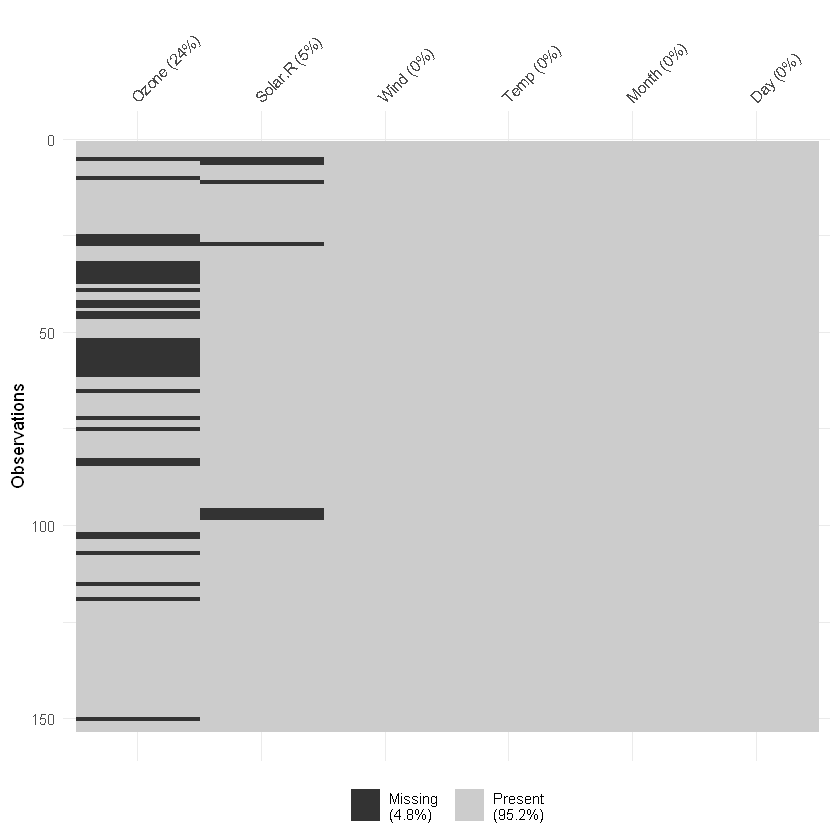

In [111]:
visdat::vis_miss(airquality)

Let's see if there are any differences between the rows with missing and non-missing ozone values:

In [115]:
airquality %>%
  mutate(miss_ozone = is.na(Ozone)) %>%
  group_by(miss_ozone) %>%
  summarize(across(everything(), median, na.rm = TRUE))

miss_ozone,Ozone,Solar.R,Wind,Temp,Month,Day
<lgl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,31.5,207,9.7,79,7,16
TRUE,NA,194,9.7,79,6,15


☝️ here there is no detectable difference, the NAs are probably random.

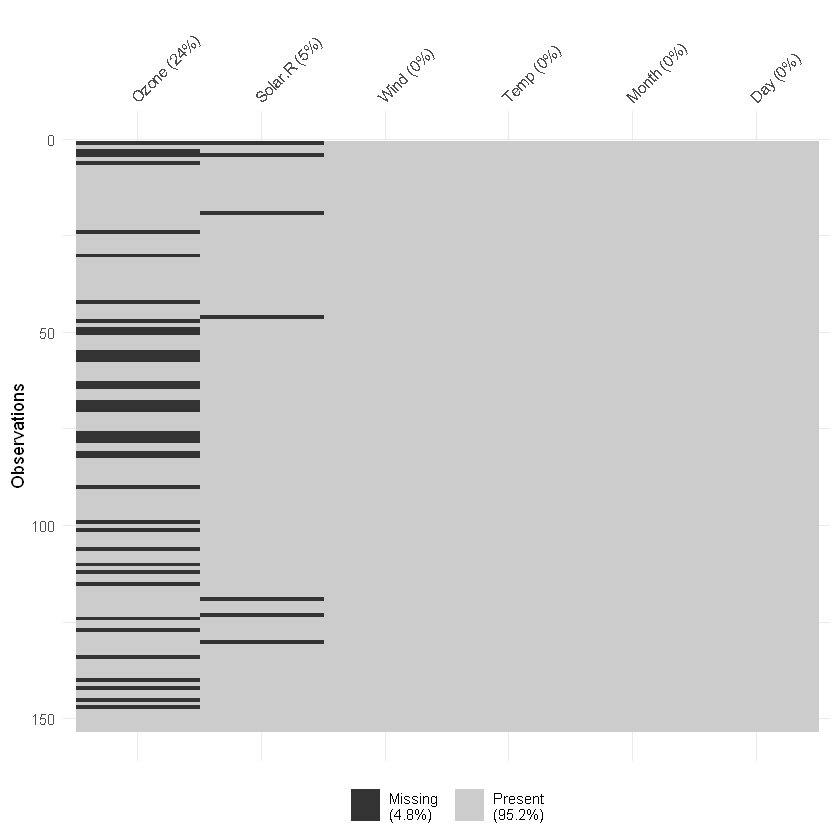

In [116]:
airquality %>%
  arrange(Temp) %>%
  visdat::vis_miss()

☝️ No cluster in NAs when arrenging by Temp, the pattern looks random. 

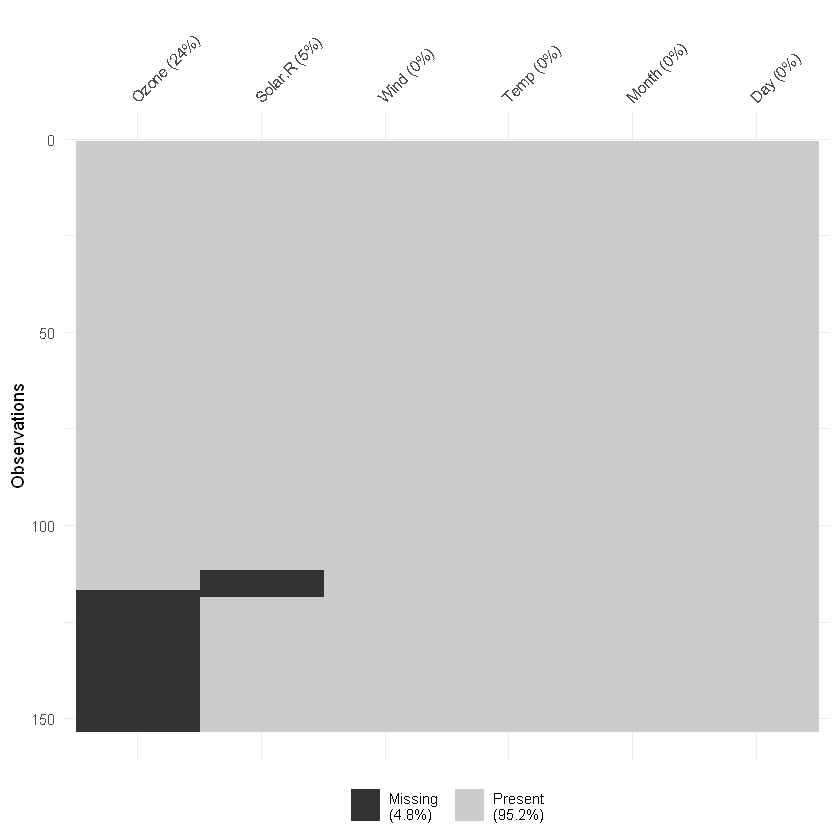

In [345]:
airquality %>%
  visdat::vis_miss(cluster = TRUE)

☝️ `cluster = TRUE`  orders the rows by missingness to identify common co-occurrences to find patterns.

The `naniar` package also provides plots for missing data visualization, corresponding to the summary functions in the previous chapter:
- `gg_miss_var()` - visualize missing data per variables 
- `gg_miss_case()` - visualize missing data per rows 
- `gg_miss_upset()` - visualize which variables and cases go missing together
- `gg_miss_fct` - heatmap visualization to explore how missingness in each variable changes across a factor showing the factors on the x axis, each other variable on the y axis, and the amount of missingness colored from dark purple to yellow.
- `gg_miss_span` - This calculates the number of missings in a given span (e.g. the number of missings for every 3000 rows). It displays the amount of missing values in each span in a filled barplot. 

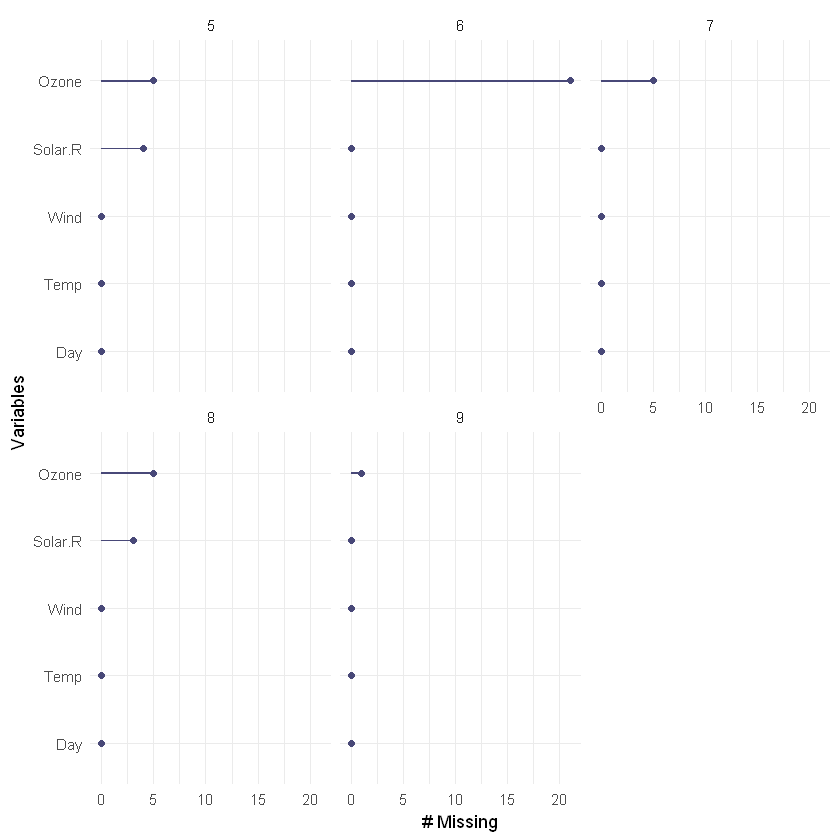

In [359]:
naniar::gg_miss_var(airquality, facet = Month)

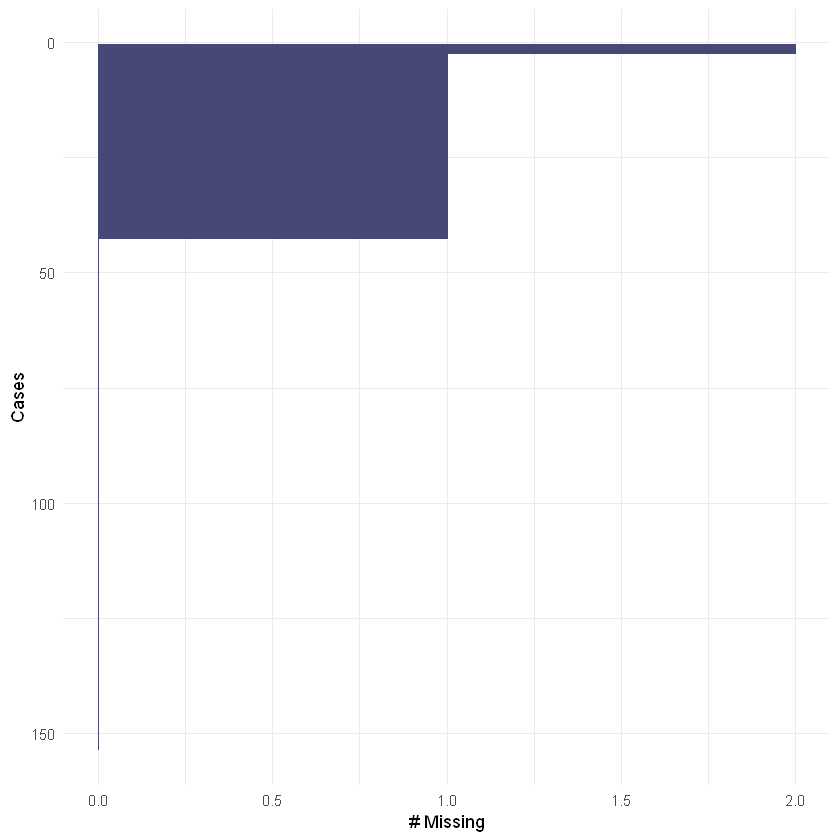

In [351]:
naniar::gg_miss_case(airquality)

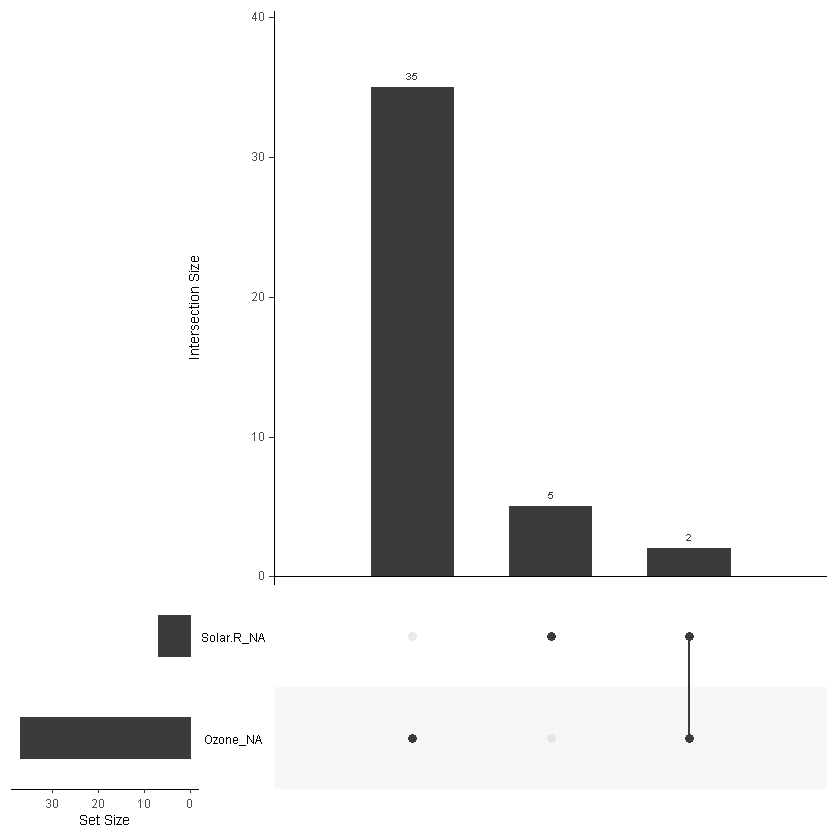

In [353]:
naniar::gg_miss_upset(airquality)

☝️ There are only missing values in `Ozone` and `Solar.R`, with 35 in only `Ozone`, 5 in `Solar.R`, and in both `Ozone` and `Solar.R`, there are 2 missing cases.

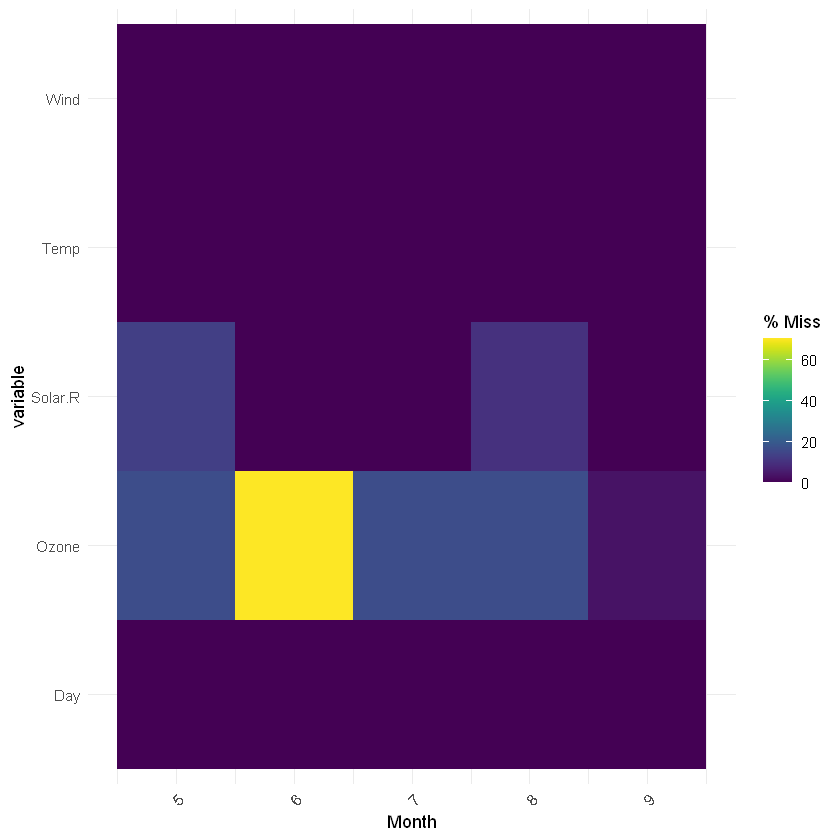

In [356]:
naniar::gg_miss_fct(airquality, fct = Month)

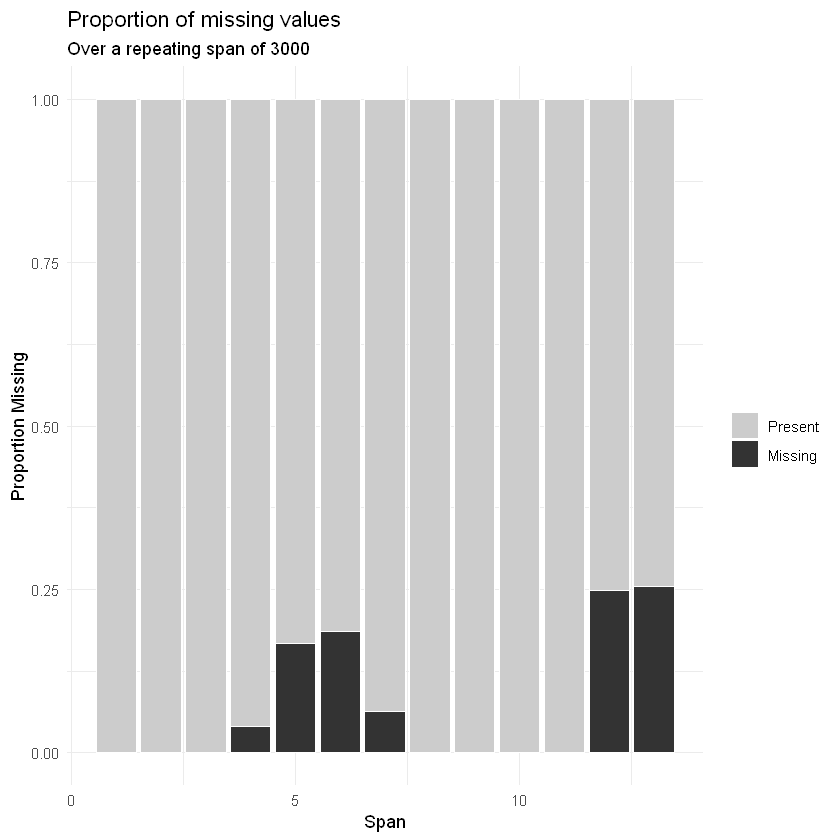

In [357]:
naniar::gg_miss_span(pedestrian, hourly_counts, span_every = 3000)

<a name="toc_00232_4.4"></a>
**4.4 Finding and replacing missing values**

When handling missing values, we should not assume that they will always be represented with `NA` in the dataset. They may be coded as a `"N/A"`, `"missing"`, `"."`, `-99` or other strings, characters or numbers.

The `miss_scan_count()`  function from the `naniar` package takes a dataframe and a `search` parameter - a list of values to search for. This returns a dataframe with two columns: `Variable` - the variables, and `n`, the number of times that search appears in each variable. 

To replace missing values, use `replace()` with the `mutate()` function, or use `replace_with_na()` from the `naniar` package.

In [362]:
chaos <- tibble(
    score = c(3, -99, 4, -99, 7, 10, 12, 16, 9),
    grade = c("N/A", "E", "missing", "na", "n/a", NA, ".", NA, "N/a"),
    place = c(-99, 97, 95, 92, -98, "missing", 88, ".", 86)
    )

In [367]:
naniar::miss_scan_count(chaos, "N/A")

Variable,n
<chr>,<int>
score,0
grade,1
place,0


☝️ Here, we see that searching for `"N/A"` returns `1` hit for the variable, `grade`.

In [371]:
chaos %>%
  mutate(grade = replace(grade, grade == "N/A", NA))

score,grade,place
<dbl>,<chr>,<chr>
3,NA,-99
-99,E,97
4,missing,95
-99,na,92
7,n/a,-98
10,NA,missing
12,.,88
16,NA,.
9,N/a,86


In [378]:
chaos %>%
  replace_with_na(replace = list(grade = c("N/A", "n/a", "N/a", "na", "missing", ".")))

score,grade,place
<dbl>,<chr>,<chr>
3,NA,-99
-99,E,97
4,NA,95
-99,NA,92
7,NA,-98
10,NA,missing
12,NA,88
16,NA,.
9,NA,86


We can handle NAs in multiple columns at once with the following functions:
- `across()` with the `mutate()` statement
- `replace_with_na_all(condition = ~.x == "N/A")` - to replace NAs is all variables (`naniar` package)
- `replace_with_na_at()` - a subset of selected variables
- `replace_with_na_if()`  - a subset of variables that fulfill some condition (numeric, character)

In [380]:
chaos %>%
  mutate(across(everything(), ~ ifelse(is.na(.), 0, .))) 

score,grade,place
<dbl>,<chr>,<chr>
3,N/A,-99
-99,E,97
4,missing,95
-99,na,92
7,n/a,-98
10,0,missing
12,.,88
16,0,.
9,N/a,86


In [401]:
chaos %>%
  naniar::replace_with_na_all(condition = ~ str_to_upper(.x) %in% c("N/A", "MISSING", "NA", -99, "."))

score,grade,place
<dbl>,<chr>,<chr>
3,NA,NA
NA,E,97
4,NA,95
NA,NA,92
7,NA,-98
10,NA,NA
12,NA,88
16,NA,NA
9,NA,86


In the dataset below, there are only two recorded measurements for Sam - he has morning and afternoon. Sam is missing a score evening! It's not recorded as missing, but it is not there! 

<div style="text-align:center;">
  <img src="images/clean_40.png" width = "200" align="center">
</div>

This becomes clearer if we spread out the data, so that we have one column for afternoon, evening, and morning. Notice how there is now a missing value for the evening for Sam! The missing value here wasn't shown before, because it was actually...missing!

<div style="text-align:center;">
  <img src="images/clean_41.png" width = "300" align="center">
</div>

To make these implicit missings explicit, we can use the `complete()` function from `tidyr`. Here, you take the data then use the `complete()` function, passing it the variables that you want it to find unique combinations of. 

In [405]:
dt <- expand.grid(name = c("A", "B", "C"), time = c("morning", "afternoon", "evening")) %>%
      mutate(value = 1:9) %>%
      filter(!(name == "B" & time == "evening"))

dt 

name,time,value
<fct>,<fct>,<int>
A,morning,1
B,morning,2
C,morning,3
A,afternoon,4
B,afternoon,5
C,afternoon,6
A,evening,7
C,evening,9


☝️ The `name == "B"` and `time == "evening"` case is missing, but we want a row with `NA` instead for that case.

In [404]:
dt %>%
  complete(name, time)

name,time,value
<fct>,<fct>,<int>
A,morning,1
A,afternoon,4
A,evening,7
B,morning,2
B,afternoon,5
B,evening,NA
C,morning,3
C,afternoon,6
C,evening,9


☝️ Now the dataset is complete!

Sometimes missing data is entered to help make a dataset more readable. For example, imagine if we had the structure below for our tetris data. We know something about the data structure here, and what we want to do is **fill these values down**. This method is called **last-observation carried forward (LOCF)**. Handling missing values in this way is useful in cases where there is some structure to the data that makes it easy to know what the missing value is. So make sure you are careful with this technique, it only solves a few missing data problems.

<div style="text-align:center;">
  <img src="images/clean_42.png" width = "500" align="center">
</div>

To do this, we can use the `fill()` function from `tidyr`.

In [408]:
dt2 <-tibble(name = c("A", NA, NA, "B", NA, NA, "C", NA, NA),
            value = 1:9)

dt2

name,value
<chr>,<int>
A,1
NA,2
NA,3
B,4
NA,5
NA,6
C,7
NA,8
NA,9


In [410]:
dt2 %>%
  fill(name)

name,value
<chr>,<int>
A,1
A,2
A,3
B,4
B,5
B,6
C,7
C,8
C,9


<a name="toc_00232_4.5"></a>
**4.5 Categories of missing values**

<u>Missing data can be categorized as follows:</u>

- **MCAR** (Missing Completely Random) - no relationship with other values. Probably caused by entry errors when imputting data. The `vis_miss` plot shows no clusters, the pattern is random even after setting `cluster = TRUE`. E.g.:
    - Questionnaires were randomly lost in the mail
    - Test scores from a workplace may be missing for some workers on vacation
    
<div style="text-align:center;">
  <img src="images/clean_44.png" width = "300" align="center">
</div>

- **MAR** (Missing At Random) - relationship with other *observed* data. E.g.:
    - Test scores are missing for students from a certain school district, but not the others.
    - Younger people were less likely to get their blood pressure checked at the doctor, so their medical records were missing blood pressure data
    - Missing ozone data for high temperatures (not as in the example below)
    
<div style="text-align:center;">
  <img src="images/clean_45.png" width = "500" align="center">
</div>

- **MNAR** (Missing Not At Random) - relationship with other *unobserved* data. E.g.:
    - A scale has a limit of 30 lbs, so shipments above 30 lbs don't have a recorded weight
    - Blood samples tested during the night shift were more likely to be contaminated, creating missing test results, but time of testing wasn't recorded
    - Missing temperature values for high temperatures.

<div style="text-align:center;">
  <img src="images/clean_46.png" width = "350" align="center">
</div>

<u>How to handle missing data?</u>

- Drop missing data
- **Impute** (fill in) with statistical measures (mean, median, mode...) or domain knowledge
- Impute using an algorithmic approach
- Impute with machine learning models

The appropriate method depends on the category of missingness.
- Appropriate methods for MCAR missing data:
    - Imputation is advisable
    - Deleting observations may reduce sample size, limiting inference, but will not bias. It should only be done if missing data <= 5% of all data.
    $$$$
- Appropriate methods for MAR missing data:
    - Imputation is advisable
    - Deleting observations is not ideal, and may lead to bias. Generally, deleting observations is safer for MCAR data than deleting observations for MAR data.
    $$$$
- Appropriate methods for MNAR missing data:
    - Data will be biased from deletion and imputation
    - Inference can be limited, procedd with caution

<a name="toc_00232_4.6"></a>
**4.6 Shadow matrix and Nabular data**

Let's imagine that we have some census data that contains two columns: income, and education. We note that there are some missing values in education. If we look at the distribution of income, we see that it looks like most of the values are around 70 to 80 thousand dollars a year. But if we fill the distributions according to whether or not education is missing, we see that there is a distinct gap between the two. To help us build plots like this, and explore how values are related to missingness, we are going to need some special data structures, like the shadow matrix and nabular data, and demonstrates how they can be used in analysis.

<div style="text-align:center;">
  <img src="images/clean_47.png" width = "500" align="center">
</div>

The **Shadow matrix** A shadow matrix is a simple way to keep track of which observations were originally missing. It has the following features: 

<div style="text-align:center;">
  <img src="images/clean_48.png" width = "600" align="center">
</div>

- Coordinated names: Variables in the shadow matrix gain the same name as in the data, with the suffix `"_NA"`. This makes the variables missingness straightforward to refer to. 
- Clear values. The values are either `!NA` = "not missing", or `NA` = "missing". This is clearer than ones and zeros for missing/not missing.

The **Nobular data** is practically the shadow matrix, that is attached, column-wise, to the data. This can be done with `bind_shadow(data)` from the `naniar` package. You can also use `nabular` instead of `bind_shadow`, if you like. 

<div style="text-align:center;">
  <img src="images/clean_49.png" width = "400" align="center">
</div>

In [426]:
naniar::bind_shadow(airquality) %>%
  head()

Ozone,Solar.R,Wind,Temp,Month,Day,Ozone_NA,Solar.R_NA,Wind_NA,Temp_NA,Month_NA,Day_NA
<int>,<int>,<dbl>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
41,190,7.4,67,5,1,!NA,!NA,!NA,!NA,!NA,!NA
36,118,8.0,72,5,2,!NA,!NA,!NA,!NA,!NA,!NA
12,149,12.6,74,5,3,!NA,!NA,!NA,!NA,!NA,!NA
18,313,11.5,62,5,4,!NA,!NA,!NA,!NA,!NA,!NA
NA,NA,14.3,56,5,5,NA,NA,!NA,!NA,!NA,!NA
28,NA,14.9,66,5,6,!NA,NA,!NA,!NA,!NA,!NA


In [427]:
airquality %>%
  bind_shadow() %>%
  group_by(Ozone_NA) %>%
  summarize(mean = mean(Wind))

Ozone_NA,mean
<fct>,<dbl>
!NA,9.862069
NA,10.256757


We can use nabular data to explore how you can use nabular data to explore how variables vary as other variables go missing.

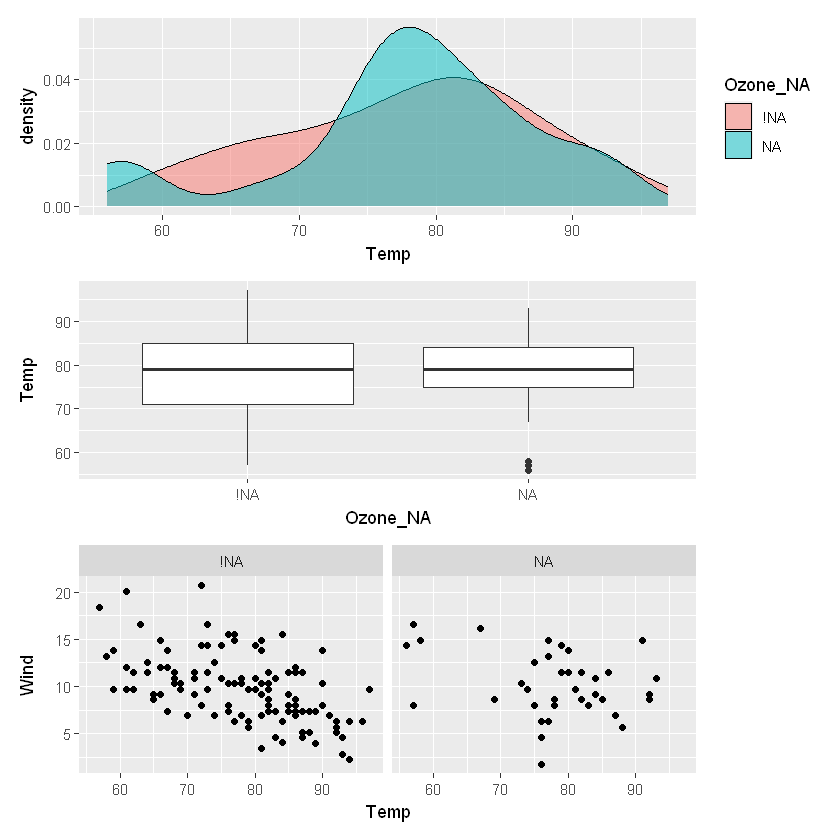

In [443]:
library(patchwork)

a <- ggplot(bind_shadow(airquality), aes(x = Temp, fill = Ozone_NA)) +
       geom_density( alpha = 0.5)

b <- ggplot(bind_shadow(airquality), aes(y = Temp, x = Ozone_NA)) +
       geom_boxplot()

c <- ggplot(bind_shadow(airquality), aes(x = Temp, y = Wind)) +
       geom_point() +
        facet_wrap(.~Ozone_NA)

a / b / c

The problem with visualizing a scatter plot when the data has missing values is that it removes any observations - entire rows - that have missing values. ggplot is actually very nice gives a warning that missing values are being dropped. The same cannot be said of other all functions in R! To explore the missings in a scatter plot, we can use `geom_miss_point()`. It visualizes the missing values by placing them in the margins. 

`geom_miss_point` performs a transformation on the data and actually imputes the values that are missing with the value 10% below the minimum value (as shown below in the column `ozone_shift` column) and then keeps track of where it is, to show it in the visualization - as shown here with `Ozone_NA`.

<div style="text-align:center;">
  <img src="images/clean_50.png" width = "250" align="center">
</div>

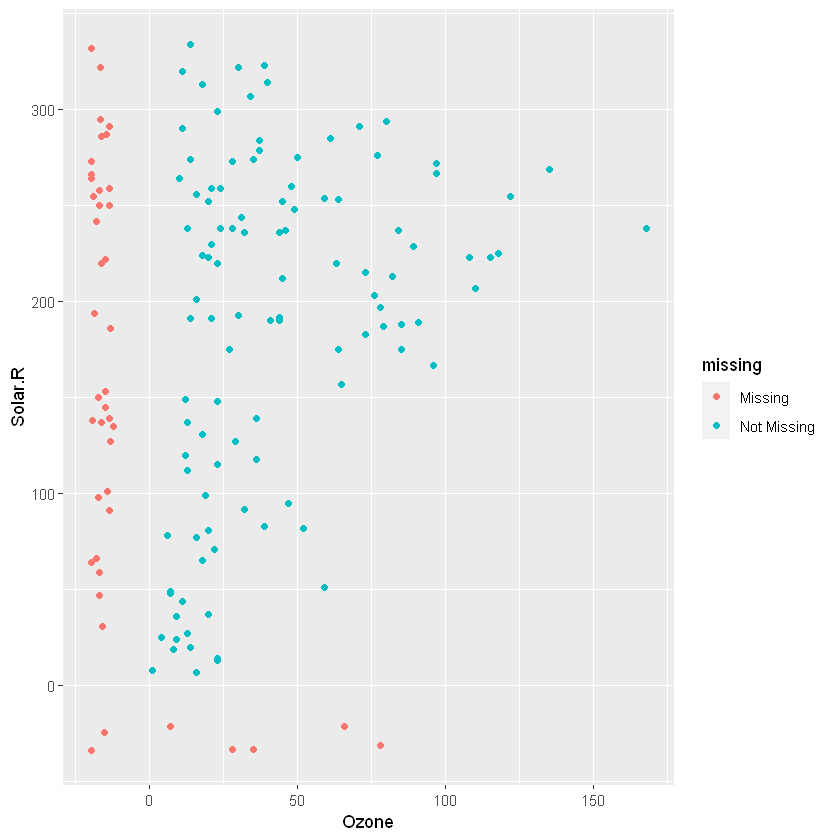

In [447]:
airquality %>%
    ggplot(aes(x = Ozone, y = Solar.R)) +
       naniar::geom_miss_point()

 ☝️ This shows us that the values of `Solar.R` are reasonably uniform. The values of `Ozone` when `Solar.R` is missing are shown in red on the bottom, this shows us that the missing values tend to occur at lower values of Ozone. In the bottom left we show cases where there are missings in both `Ozone` and `Solar.R`.

We can even use nabular data and explore the missingness by another variable being missing. For example, we can explore how the missingness changes when Solar Radiation is missing:

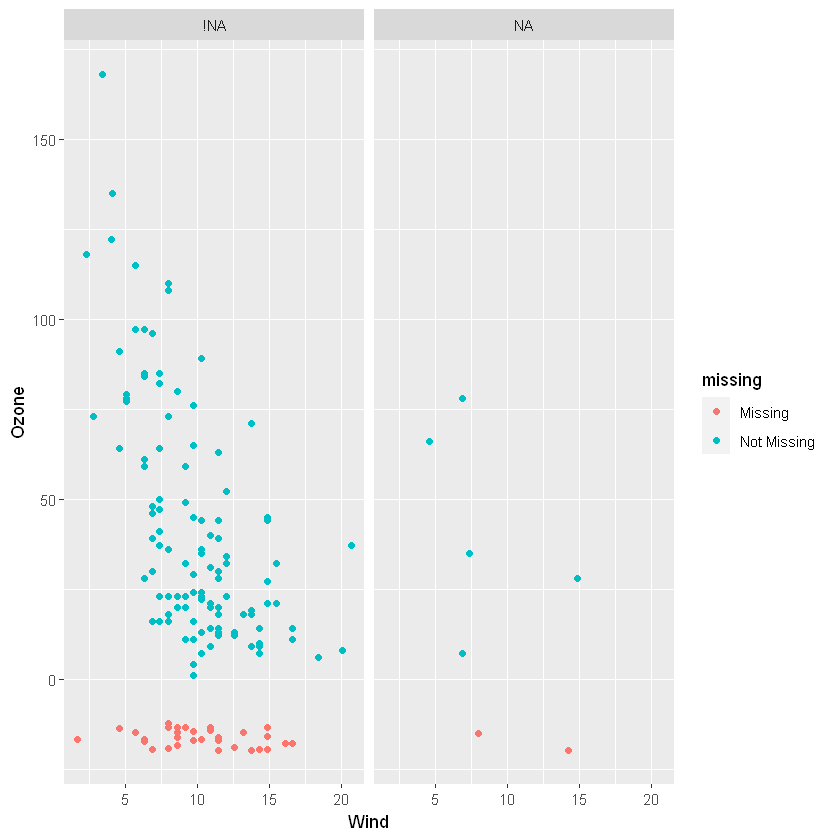

In [448]:
airquality %>%
  bind_shadow() %>%
  ggplot(aes(x = Wind, y = Ozone)) +
  geom_miss_point() +
  facet_wrap(~ Solar.R_NA)

<a name="toc_00232_4.7"></a>
**4.7 Imputation methods**

Imputing missing values needs to be done with care - you want to avoid imputing unlikely values like pregnant males, or winter temperatures on a warm summers day. 

It is important to check the variable's distribution (mean, median, spread, scale) before chosing the imputation method! For example, 
**mean imputation**, which takes the mean of complete values and uses this to impute it into the missing values, can be useful in some cases where there are only a small amount of missing values and they come from a normal distribution (like imputing the avg. weight for certain subjects with missing data), but can be a bad idea for example in cases like below. Another problem with mean imputation is that we will always impute the same mean value in place of each NA, so there will be not natural spread in the imputed data so it will artificially increases the mean and reduces variance.

<div style="text-align:center;">
  <img src="images/clean_51.png" width = "600" align="center">
</div>

Model-based imputation methods provide better options than simple imputations. The `simputation` package can be used for this purpose.


The `naniar` package contain some imputation methods:
- `impute_below()` - imputes values below the range of the data. Used mostly to aid visualization
    - `impute_below_if(data, is.numeric)` - only imputes variables that satisfy a condition, like is.numeric
    - `impute_below_at(data, vars(var1, var2))` - imputes variables specified inside vars
    - `impute_below_all(data)` - impute all variables
- `impute_mean()` - imputes the mean value. It also has `_if`, `_at` and `_all` variants.
- `impute_lm()` - impute values using a linear model. It is from the `simputation` package.

<u>Using `impute_below()` and its variants</u>

In [7]:
naniar::impute_below(c(5, 6, 7, NA, 9, 10)) %>% round(1)

[1]  5.0  6.0  7.0  4.4  9.0 10.0

☝️ for this vector it imputes the value `4.4` into the missing value, since this is lower than the lowest value of the data at hand, namely `5.0`. 

In [18]:
airquality[5,] # or alternatively: airquality %>% slice(5)

,Ozone,Solar.R,Wind,Temp,Month,Day
,<int>,<int>,<dbl>,<int>,<int>,<int>
5,NA,NA,14.3,56,5,5


In [22]:
impute_below_if(airquality, is.numeric) %>% 
  slice(5)

Ozone,Solar.R,Wind,Temp,Month,Day
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
-19.72321,-33.57778,14.3,56,5,5


In [26]:
impute_below_at(airquality, vars(Ozone))  %>% 
  slice(5)

Ozone,Solar.R,Wind,Temp,Month,Day
<dbl>,<int>,<dbl>,<int>,<int>,<int>
-19.72321,NA,14.3,56,5,5


We can use the below imputed values to create plots, similar to `geom_miss_point()` but not just for scatterplots:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


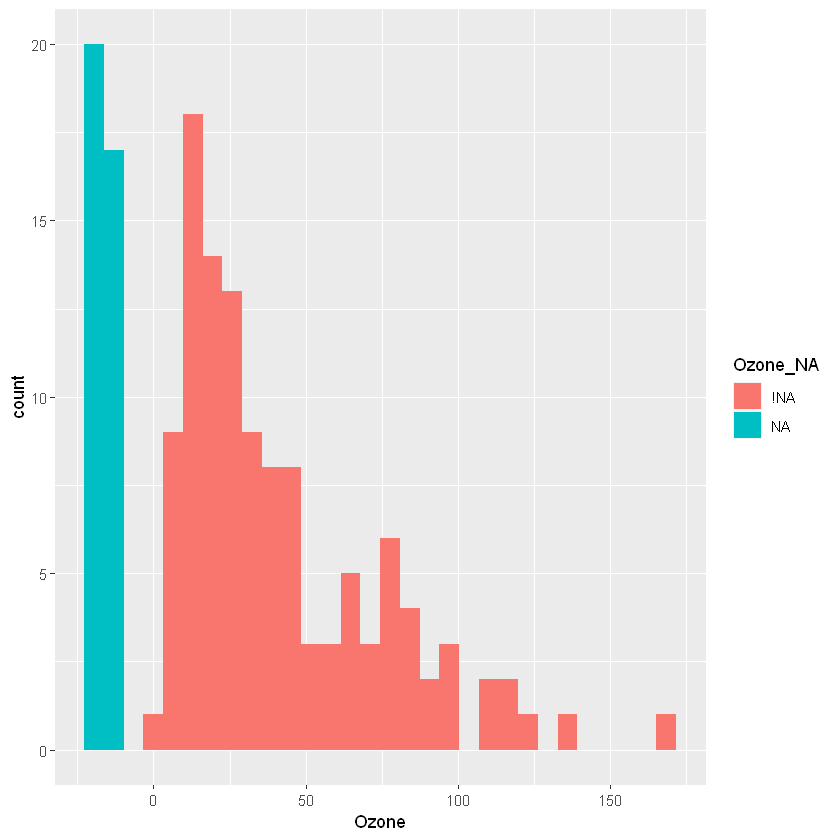

In [31]:
airquality %>% 
  bind_shadow() %>% 
  impute_below_all() %>% 
  ggplot(aes(x = Ozone, fill = Ozone_NA)) +
    geom_histogram()

☝️ Here we see that there are a few missing values - two bars around 20, so just under 40 missing values.

To visualize missings for two variables, we need to add a label that identifies whether there is a missing value in a column. The function `add_label_shadow()` does this for us. It creates a column called `any_missing` that has the value `Not Missing` or `Missing`.

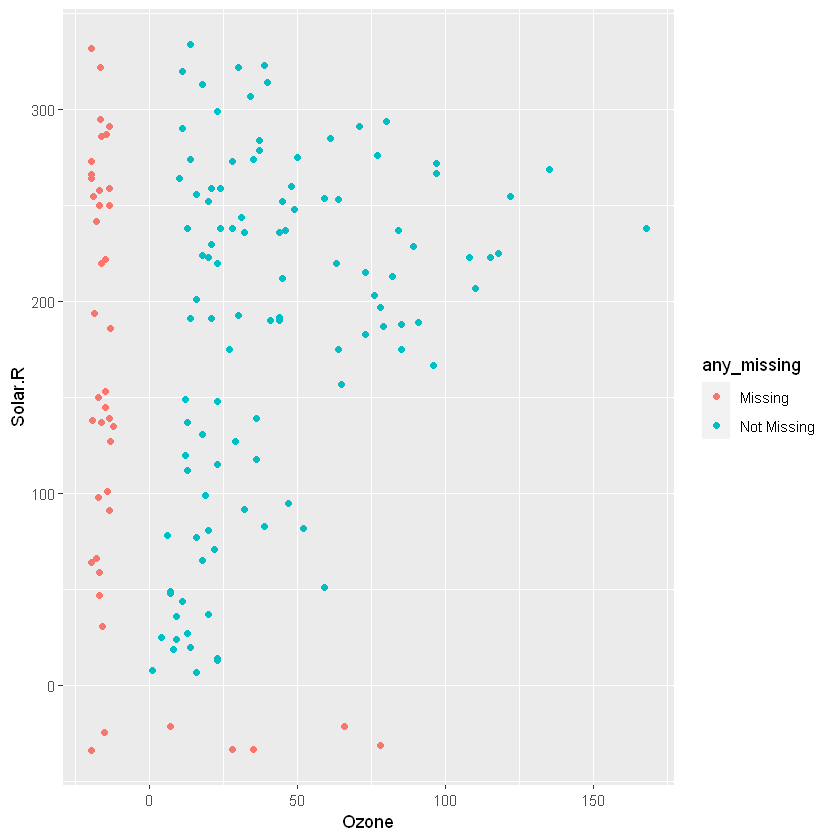

In [36]:
airquality %>% 
  bind_shadow() %>% 
  add_label_shadow() %>% 
  impute_below_all() %>% 
  ggplot(aes(x = Ozone, y = Solar.R, color = any_missing)) +
    geom_point()

☝️  We have now recreated the same figure as `geom_miss_point()` above!

<u>Using `impute_mean()`</u>

In [41]:
naniar::impute_mean(c(62.1, NA, 60.2, 60.8, 61.6)) %>% round(1)

[1] 62.1 61.2 60.2 60.8 61.6

☝️ In this case, the values are probably came from a normal distribution, so the mean imputation works fine.

In [39]:
naniar::impute_mean(c(NA, 5, 6, 7, 8, 9, 10)) %>% round(1)

[1]  7.5  5.0  6.0  7.0  8.0  9.0 10.0

☝️ In this case, our vector contains a series of data and not normally distributed values. The missing value is probably `4`, which is less then the average of `7.5`. The mean imputation is not a good idea here.

The spread of imputations can be explored using a scatter plot:

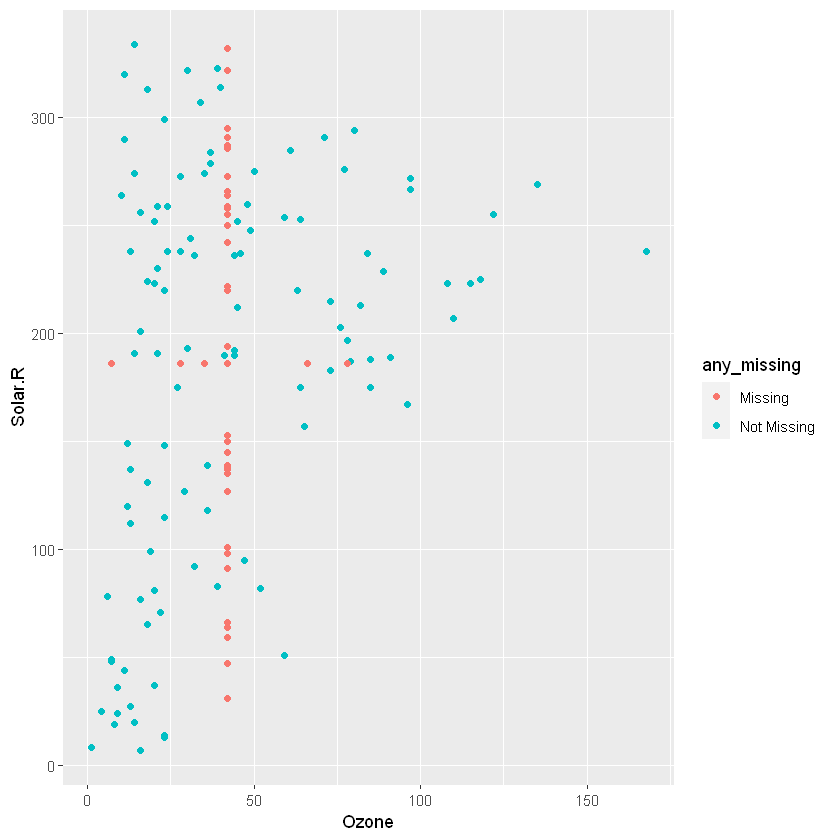

In [44]:
airquality %>% 
  bind_shadow() %>% 
  add_label_shadow() %>% 
  impute_mean_if(is.numeric) %>% 
  ggplot(aes(x = Ozone, y = Solar.R, color = any_missing)) +
    geom_point()

☝️ This visualization shows that after mean imputation, there is no variation in the spread of the points, as the mean isn't changing! Although we do notice that the imputed values are within the same range of the data. This is probably not ideal but not terrible either.

<u>Using `impute_lm()`</u>

In [52]:
 airquality %>%  slice(5)

Ozone,Solar.R,Wind,Temp,Month,Day
<int>,<int>,<dbl>,<int>,<int>,<int>
NA,NA,14.3,56,5,5


In [70]:
airna <- airquality %>% 
  mutate(Ozone_NA = ifelse(is.na(Ozone), "NA", "!NA"),
        Solar_NA = ifelse(is.na(Solar.R), "NA", "!NA"))

airna %>% 
  simputation::impute_lm(Ozone ~ Wind + Temp + Month) %>% 
  simputation::impute_lm(Solar.R ~ Wind + Temp + Month) %>% 
  slice(c(4,5))

Ozone,Solar.R,Wind,Temp,Month,Day,Ozone_NA,Solar_NA
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<chr>
18.000000,313.0000,11.5,62,5,4,!NA,!NA
-9.039337,137.6006,14.3,56,5,5,NA,NA


Now let's compare results from two different linear models:

In [76]:
mod1 <- airna %>% 
  simputation::impute_lm(Ozone ~ Wind + Temp + Month) %>% 
  simputation::impute_lm(Solar.R ~ Wind + Temp + Month) 

mod2 <- airna %>% 
  simputation::impute_lm(Ozone ~ Wind + Temp + Month + Day) %>% 
  simputation::impute_lm(Solar.R ~ Wind + Temp + Month + Day)

bound_models <- bind_rows(small = mod1, large = mod2, .id = "imp_model")

bound_models %>%  
  group_by(imp_model) %>%  
  slice(5)

imp_model,Ozone,Solar.R,Wind,Temp,Month,Day,Ozone_NA,Solar_NA
<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<chr>
large,-12.461546,152.0729,14.3,56,5,5,NA,NA
small,-9.039337,137.6006,14.3,56,5,5,NA,NA


☝️ Check how much of a difference it made to add `Day` as an explanatory variable. Here it is not too bad, but good model specification is key for imputation!

New names:
* `Ozone_NA` -> `Ozone_NA...8`
* `Ozone_NA` -> `Ozone_NA...11`


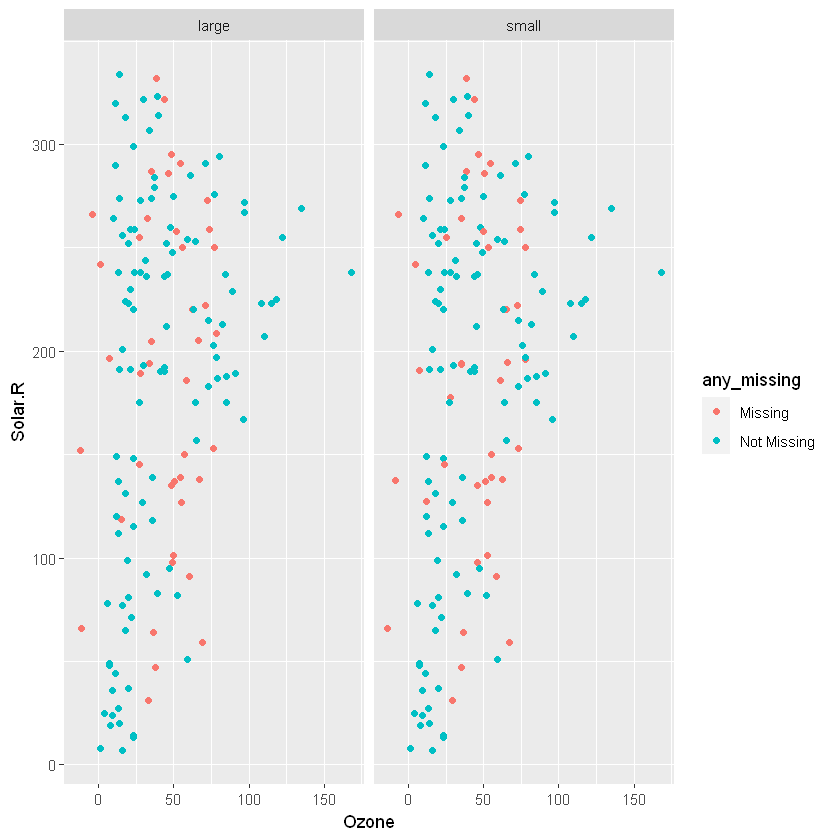

In [78]:
bound_models %>% 
  bind_shadow() %>% 
  add_label_shadow() %>% 
  ggplot(aes(Ozone, Solar.R, color = any_missing)) +
  geom_point() +
  facet_wrap(.~ imp_model)

☝️ Visual inspection of imputation differences. No significant difference can be detected here. The imputation was much more successful than with the mean imputation before!

Next, to explore the imputations across these different models and variables, we can use `gather` on the selected variables and plot the data as a boxplot faceting the different values for each variable:

In [82]:
bound_models_gather <- bound_models %>% 
  bind_shadow() %>% 
  add_label_shadow() %>% 
  select(Ozone, Solar.R, any_missing, imp_model) %>% 
  gather(key = "variable", value = "value", -any_missing, -imp_model)

head(bound_models_gather)

New names:
* `Ozone_NA` -> `Ozone_NA...8`
* `Ozone_NA` -> `Ozone_NA...11`


any_missing,imp_model,variable,value
<chr>,<chr>,<chr>,<dbl>
Not Missing,small,Ozone,41.000000
Not Missing,small,Ozone,36.000000
Not Missing,small,Ozone,12.000000
Not Missing,small,Ozone,18.000000
Missing,small,Ozone,-9.039337
Missing,small,Ozone,28.000000


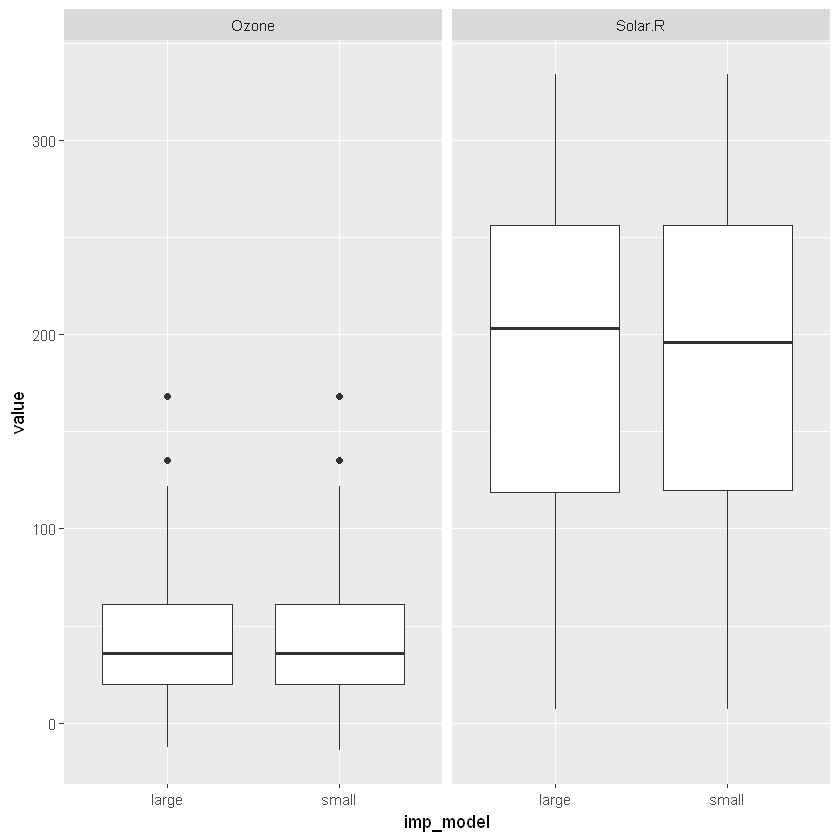

In [85]:
bound_models_gather %>%
  ggplot(aes(x = imp_model, y = value)) +
  geom_boxplot() +
  facet_wrap(.~ variable)

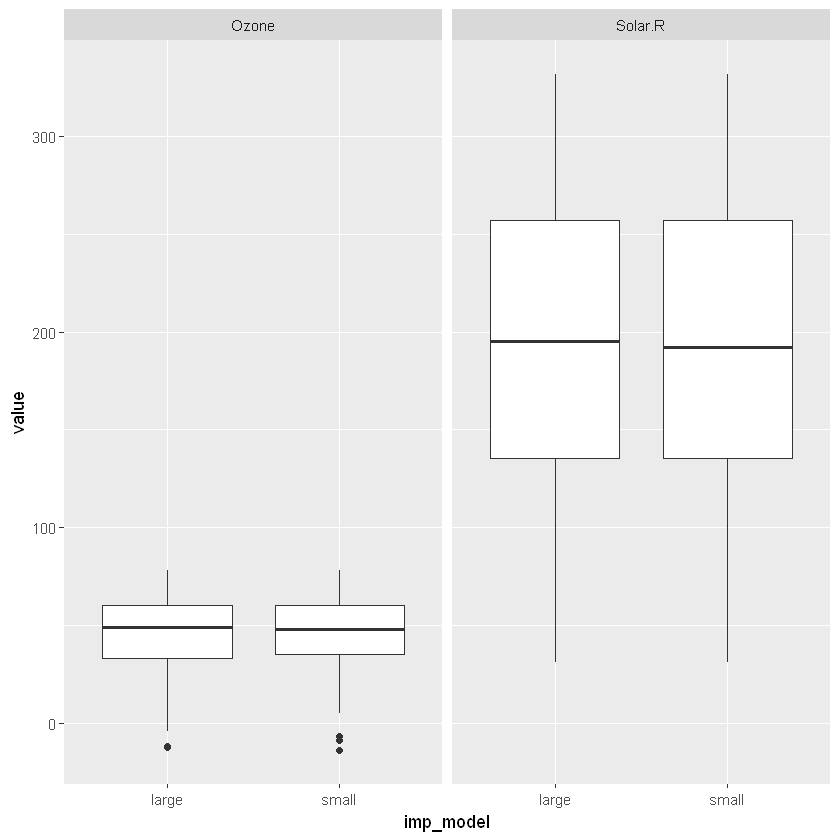

In [86]:
bound_models_gather %>% 
filter(any_missing == "Missing") %>% 
ggplot(aes(x = imp_model, y = value)) +
  geom_boxplot() +
  facet_wrap(.~ variable)

 ☝️ Again, there isn't much difference between the models (not for the whole variable and not for the missing data either), so `Day` is probably not an important explanatory variable.

<u>Evaluating imputations and models</u>

Our goal will be to assess model inference across differently imputed datasets. Let's compare the model with complete cases (i.e. NAs are simply dropped) and the model with linear imputation. 

To evaluate the different imputation methods, we need to put them into a single dataframe. Here, we will use our two models to build  linear models with `Temp` as the dependent variable, and we will compare the goodness of these models to see how imputation affected the information in the data.

First, let's prepare a nested object containing both the complete cases and imputed datasets:

In [98]:
# Complete cases
aq_cc <- airquality %>%
  na.omit()  %>% 
  mutate(Ozone_NA = ifelse(is.na(Ozone), "NA", "!NA"),
        Solar_NA = ifelse(is.na(Solar.R), "NA", "!NA"))

# Imputation using the imputed data earlier
mod2 <- airna %>% 
  simputation::impute_lm(Ozone ~ Wind + Temp + Month + Day) %>% 
  simputation::impute_lm(Solar.R ~ Wind + Temp + Month + Day)

# Bind models together

bound_models2 <- bind_rows(cc = aq_cc,
                          imp_lm = mod2,
                          .id = "imp_model")

Now that we've got our data in the right format, we fit a linear model to each of the datasets. We use the **"many models"** approach, which is covered in more detail in the R for data science book by Hadley Wickham and Garrett Grolemund:

In [114]:
model_summary <- bound_models2 %>%
  group_by(imp_model) %>%
  nest() %>% #  collapse the data down so each row is one of our datasets
  mutate(mod = map(data, ~ lm(Temp ~ Ozone + Solar.R, data = .)), # create linear models on each row of the data
         res = map(mod, residuals), # map tells the function we are applying to look at the data
         pred = map(mod, predict), # create separate columns for predictions
         tidy = map(mod, broom::tidy)) # create separate columns for coefficients

print(model_summary)

# A tibble: 2 x 6
# Groups:   imp_model [2]
  imp_model data               mod    res         pred        tidy            
  <chr>     <list>             <list> <list>      <list>      <list>          
1 cc        <tibble [111 x 8]> <lm>   <dbl [111]> <dbl [111]> <tibble [3 x 5]>
2 imp_lm    <tibble [153 x 8]> <lm>   <dbl [153]> <dbl [153]> <tibble [3 x 5]>


Now, we explore the model coefficients (tidy column) and unnesting:

In [115]:
model_summary %>%
  select(imp_model, tidy) %>%
  unnest()

Warning message:
"`cols` is now required when using unnest().
Please use `cols = c(tidy)`"


imp_model,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
cc,(Intercept),68.497102713,1.528466875,44.8142540,1.314937e-71
cc,Ozone,0.194293763,0.020977024,9.2622177,2.215559e-15
cc,Solar.R,0.006039431,0.007657852,0.7886587,4.320393e-01
imp_lm,(Intercept),67.246708873,1.304911494,51.5335402,2.683030e-97
imp_lm,Ozone,0.215068296,0.017977583,11.9631377,1.395425e-23
imp_lm,Solar.R,0.007867008,0.006296806,1.2493648,2.134777e-01


☝️ Here we see that the estimates of the impact of `Ozone` on temperature are slightly higher for the imputed dataset - note that the significance of the effect does not change.

Let's explore the residuals as well, by selecting the `res` column, and then unnesting the data:

Warning message:
"`cols` is now required when using unnest().
Please use `cols = c(res)`"
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


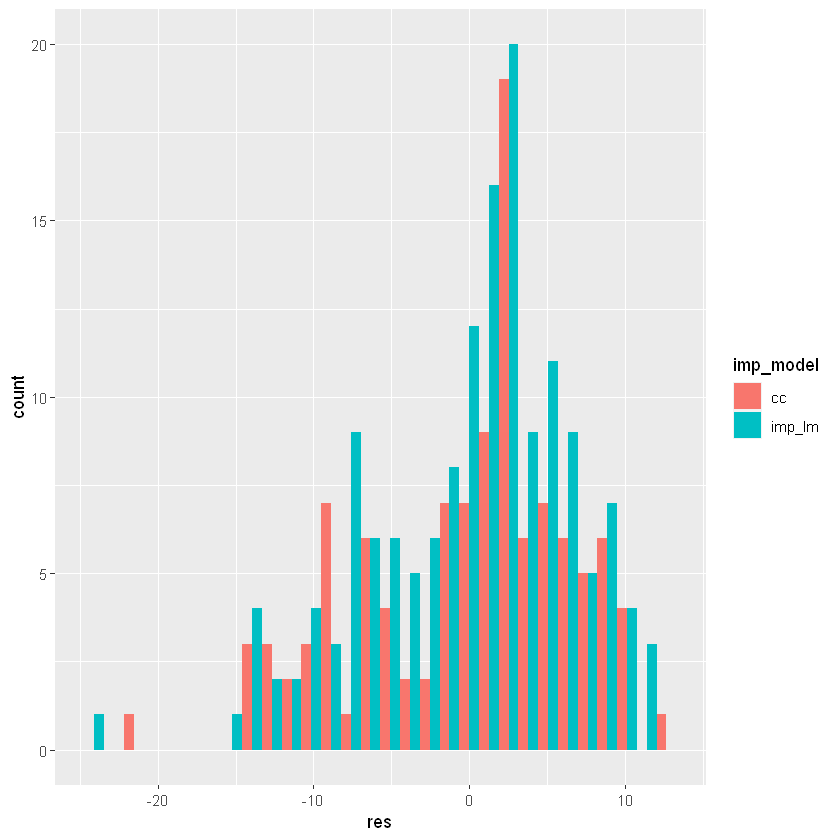

In [117]:
model_summary %>%
  select(imp_model, res) %>%
  unnest()  %>%
  ggplot(aes(x = res, fill = imp_model)) +
  geom_histogram(position = "dodge")

☝️ Surprisingly, there isn't much difference between the two models.

Finally, we can explore the predictions in the data, using a similar pattern:

Warning message:
"`cols` is now required when using unnest().
Please use `cols = c(pred)`"
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


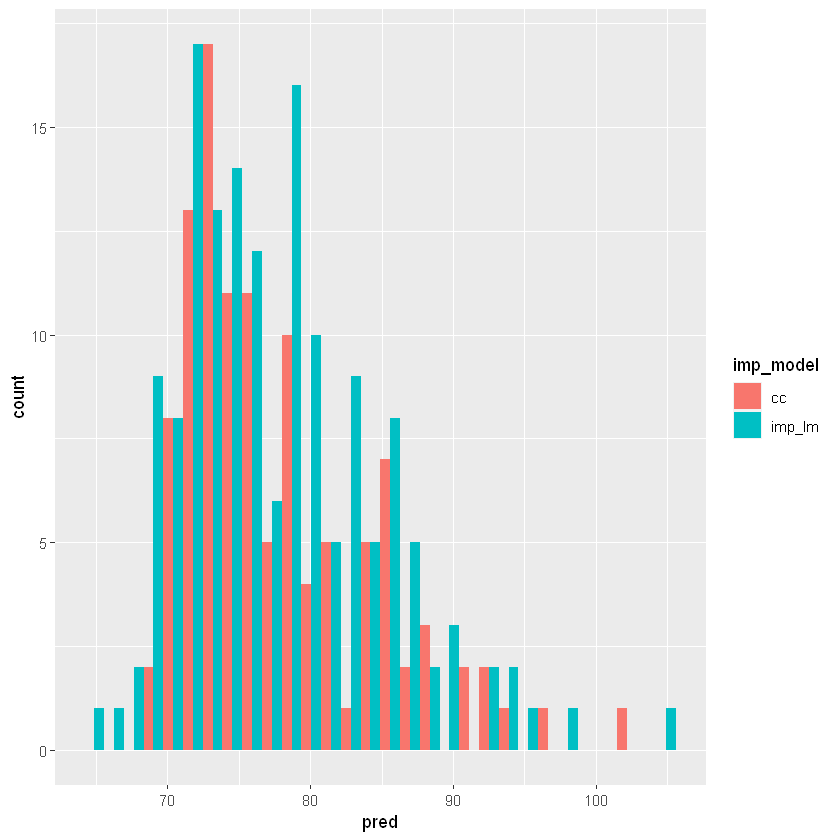

In [119]:
model_summary %>%
  select(imp_model, pred) %>%
  unnest()  %>%
  ggplot(aes(x = pred, fill = imp_model)) +
  geom_histogram(position = "dodge")

☝️ Similar to what we saw with the residuals, the predictions are quite similar to complete case, but with some more extreme values.

<a name="toc_00232_5"></a>
## 5.   Record Linkage

Record linkage is a powerful technique used to merge multiple datasets together, used when values have typos or different spellings.

<a name="toc_00232_5.1"></a>
**5.1 Comparing strings using edit distance**

**Edit distance** is a way of measuring how different two strings are from each other, based on the four basic kinds of typos, which are:
- inserting a character
- deleting a character
- substituting one character for another
- transposing, or swapping the position of characters

<div style="text-align:center;">
  <img src="images/clean_22.png" width = "200" align="center">
</div>

**Minimum edit distance** is the fewest number of typos you'd need to convert one string to another. For example, to turn "dog" into "dogs", we insert an "s".

<div style="text-align:center;">
  <img src="images/clean_23.png" width = "200" align="center">
</div>

For a more complex example, to turn "baboon" to "typhoon", the total edit distance is 4, as it takes 4 steps to make the conversion:

<div style="text-align:center;">
  <img src="images/clean_24.png" width = "150" align="center">
</div>

There are multiple types of edit distance that each calculate distance between strings a little differently. 
- **The Damerau-Levenshtein** distance is what is show above. 
- **The Levenshtein distance** does not count transposition as a single action - instead, it counts as 2: a deletion and an insertion. 
- **The Longest Common Subsequence**, or **LCS**, distance considers only insertion and deletion as actions. 
- **Jaccard distance** - The output is on a scale of `0` to `1`, where numbers closer to `0` indicate that the strings are more similar.
- **Jaro-Winkler** - more complex method

Each method has a relative advantage in different circumstances.

To calculate edit distances in R, we can use `stringdist()` from the `stringdist` package, passing it the two strings to compare and the method you want to use. In this case, we're using `"dl"`, which stands for Damerau-Levenshtein.

In [135]:
stringdist::stringdist("baboon", "typhoon", method = "dl")
stringdist::stringdist("las angelos", "los angeles", method = "dl")

[1] 4

[1] 2

In [138]:
stringdist::stringdist("baboon", "typhoon", method = "lcs")
stringdist::stringdist("los angelos", "los angeles", method = "jaccard")

[1] 7

[1] 0

When is this useful? When we want to collapse multiple categories into one, instead of using manually defined categories (which is problematic if there are too many variations to type out), we can use string distance to map them to the correct category.

<div style="text-align:center;">
  <img src="images/clean_25.png" width = "500" align="center">
</div>

An example: The survey below had free text entry, so the city column is riddled with typos. To map them to the correct spelling, we can compare the distance between each survey response and the set of possible answers, and choose the one that's closest.

<div style="text-align:center;">
  <img src="images/clean_26.png" width = "500" align="center">
</div>

The `fuzzyjoin` package allows us to do joins based on string distance. We can use `stringdist_left_join()` to join the survey data to cities. Just like the `stringdist()` function, we can pass in the method we want to use for string distance.

<div style="text-align:center;">
  <img src="images/clean_27.png" width = "450" align="center">
</div>

We can also use the `max_dist` argument to adjust how close we want the strings to be in order to consider them a match. Notice how we get an `NA`, since the typo in row 8 wasn't close enough to any of the cities to be assigned to one.

<div style="text-align:center;">
  <img src="images/clean_28.png" width = "450" align="center">
</div>

In [152]:
zagat_bad <- zagat %>%
  add_row(city = "las angelas") %>%
  count(city)

zagat_bad %>%
  stringdist_left_join(zagat, by = "city", method = "dl")  %>%
  select(city.x, city.y) %>%
  distinct()

city.x,city.y
<chr>,<fct>
atlanta,atlanta
las angelas,los angeles
las vegas,las vegas
los angeles,los angeles
new york,new york
san francisco,san francisco


<a name="toc_00232_5.2"></a>
**5.2 Record linkage: Generating and comparing pairs**

Below, we have two tables showing basketball game schedules from different television networks. If we want to get a full list of the basketball games being televised, we need to combine these two tables. However, some of the games in the second table are duplicates of games already listed in the first table. Since there's no consistent identifier between the two tables, a regular join won't work. This is where **record linkage** comes in.

<div style="text-align:center;">
  <img src="images/clean_29.png" width = "450" align="center">
</div>

Record linkage involves linking data together that comes from multiple sources that don't share a common identifier, but contain data on the same entity. The usual process is as follows:
- We start by cleaning the different datasets.
- Then, we find pairs of records, or rows, that we want to compare.
- We compare those records to each other using the earlier string comparison skills,
- and score them based on how similar they are
- Finally, we link the most similar pairs together. 

<div style="text-align:center;">
  <img src="images/clean_30.png" width = "600" align="center">
</div>

<u>Look at the dataset</u>

Here, we have two data frames, A and B, and we want to use record linkage to identify if any of the records in Table A are referring to the same person as any records in Table B.

<div style="text-align:center;">
  <img src="images/clean_31.png" width = "500" align="center">
</div>

<u>Find pairs</u>

In order to figure out whether any of the rows are matches, we'll need to compare every single row in table A with every single row in table B. To generate pairs of rows in R, we can use the `reclin2` package. The `pair_blocking()` function takes in our two data frames and returns an object that contains every possible pair of records. 

<div style="text-align:center;">
  <img src="images/clean_32.png" width = "200" align="center">
</div>

But imagine if we had a thousand rows in each table. That means we'd have a million possible pairs of records, so this approach isn't scalable. To solve this problem, what if we only choose pairs that have a matching state? This drastically reduces the number of possible pairs - now we only have 8 instead of 25. This technique is called **blocking**: we only consider pairs when they agree on the blocking variable. In this case, the blocking variable is `state`.

<div style="text-align:center;">
  <img src="images/clean_33.png" width = "500" align="center">
</div>

To use blocking, we can use the same `pair_blocking()` function, but this time use the `blocking_var` (or in `reclin2`, the `on`) argument, which takes in a column name as a string. Just as we expected, we get 8 pairs instead of 25.

<div style="text-align:center;">
  <img src="images/clean_34.png" width = "500" align="center">
</div>

<u>Compare pairs</u>

Now that we have our pairs, we'll need to compare them to see which pairs are the most similar. We can do this by piping the output of `pair_blocking` to the `compare_pairs` function. We use the `by` argument to indicate that the name column of each data frame should be compared, and the `default_comparator` argument to indicate how strings should be compared. Here, we're using the **longest common subsequence** method. Notice that there's a set of parentheses after `lcs` since we're calling a function. The output shows a table with each pair and the corresponding score between the name of each pair.

<div style="text-align:center;">
  <img src="images/clean_35.png" width = "500" align="center">
</div>

We can also compare multiple columns of the data frames by passing a vector of columns to the by argument. E.g. by using `compare_pairs(by = c("name", "zip")`), we get a score for the name column and the zip column. We can also use different methods to compare strings, such as **Jaccard** or **Jaro-Winkler**.

<u>Scoring pairs</u>

Next, we need to score the pairs. There are different methods to do this:
- One way that we could combine the separate scores is by **adding them together** using `score_simsum()`, which will create a new column called simsum that holds the total score for each row.

<div style="text-align:center;">
  <img src="images/clean_36.png" width = "500" align="center">
</div>

Here, the highest score is between row 2 in `df_A` and row 3 in `df_B`, which both referred to someone named `Keaton Snyder`. However, summing doesn't account for the fact that having a very similar name is a stronger indicator that the records refer to the same person, while having the same `sex` doesn't tell us as much.

- Instead of summing, we can use a **probabilistic way** of scoring that accounts for these differences between variables. We can use the `score_problink()` function, which gives us a **weight** for each row. The higher the weight, the more similar the pair is. The highest weight is again between Keaton Z Snyder and Keaton Snyder.

<div style="text-align:center;">
  <img src="images/clean_37.png" width = "500" align="center">
</div>

<u>Link pairs together</u>

Now that we've scored each pair, how do we pick which ones are matches? For this, we can select the pairs that we consider matches using `select_n_to_m()`. 

<div style="text-align:center;">
  <img src="images/clean_38.png" width = "500" align="center">
</div>

This will select the matches with the highest scores, ensuring that any record in one data frame is only linked to one record in the other data frame at most. Here, the only pair considered a match is row 2 of df_A and row 3 of df_B.

<div style="text-align:center;">
  <img src="images/clean_39.png" width = "500" align="center">
</div>

*Note: the package `reclin` is superseeded by `reclin2`. Syntax changes were made.